In [1]:
import torch
from torch import nn
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
import pdb 
import time
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import warnings

In [2]:
class FramesDataset(Dataset):
    def text2Tensor(self, file_data):
        #process the file data such that it's a list of lists of offset tuple in each time step
        file_data_t = []
        data_temp = []
        try:
            frame_num = file_data[0][0]
        except IndexError:
            print("index error in file:")
            print(file_data)
        traj_list = []
        frame_list = []
        for line in file_data:
            if frame_num != line[0]:
                frame_num = line[0]
                data_temp.sort(key=lambda data : data[1])
                file_data_t.append(data_temp)
                data_temp = [line]
            else:    
                data_temp.append(line)
            #keep a traj list for all trajs
            if line[1] not in traj_list:
                traj_list.append(line[1])
            if line[0] not in frame_list:
                frame_list.append(line[0])
        traj_list.sort()
        frame_list.sort()  
                        
        #get participants in each frame
        #@note here the elements are ped's index in the traj list
        participants = [[] for i in range(len(file_data_t))]
        for frame_idx, line in enumerate(file_data_t):
            for traj_idx, traj in enumerate(traj_list):
                in_flag = False
                for data in line:
                    if data[1] == traj:
                        in_flag = True
                        participants[frame_idx].append(traj_list.index(data[1]))
                if not in_flag:
                    file_data_t[frame_idx].append([frame_list[frame_idx], traj, 0., 0.])
            file_data_t[frame_idx].sort(key=lambda data : data[1])

        file_data_tensors = torch.tensor(file_data_t, device=device)
        
        participant_masks = []
        for frame_idx, line in enumerate(participants):
            participant_masks.append([[torch.tensor(1.) if i in participants[frame_idx] else torch.tensor(0.) for i in range(len(traj_list))]])
        participant_masks = torch.tensor(participant_masks, device=device)
        
        return traj_list, participant_masks, file_data_tensors              
    
    
    '''
    @func preprocess
    @param path: relative path for the raw data
    @note raw data~ col1: frame index, col2: traj index, (col3, col4): (y, x)
    @return traj_list: indices for each trajactory in raw data
            participants_masks~tensor(frame num x traj num): indicate the presence of each ped at each frame
            file_data_tensors~tensor(frame num x traj num x 4): the position of each traj at each frame
                                                                if not present default to (0,0)
    '''
    def preprocess(self, path):
        #open the file as it is
        file_data = []
        with open(path, 'r') as file:
            for line in file:
                line_data = [int(float(data)) if i < 2 else float(data) for i, data in enumerate(line.rsplit())]
                line_data[2], line_data[3] = line_data[3], line_data[2]
                file_data.append(line_data)
        file_data = sorted(file_data, key=lambda data : data[1])

        traj_counts = {}
        for line in file_data:
            if line[1] not in traj_counts:
                traj_counts[line[1]] = 1
            else:
                traj_counts[line[1]] += 1
        underpresent = []
        for k, v in traj_counts.items():
            if v < 2:
                underpresent.append(k)
        
        file_data = [data for idx, data in enumerate(file_data) if data[1] not in underpresent]
        
        file_data_sort = sorted(file_data, key=lambda data : data[0])
        
        traj_list, participant_masks, coord_tensors = self.text2Tensor(file_data_sort)
        
        #process the file data such that it contains the offsets not global coords
        file_data_off = []
        for i, line in enumerate(file_data):
            if i > 0:
                if file_data[i][1] == file_data[i-1][1]:
                    file_data_off.append([file_data[i][0], file_data[i][1], file_data[i][2]-file_data[i-1][2], file_data[i][3]-file_data[i-1][3]])
        file_data_off.sort(key=lambda data : data[0])        
        
        traj_list, participant_masks, off_tensors = self.text2Tensor(file_data_off)
        
        return traj_list, participant_masks, off_tensors, coord_tensors
    

    def __init__(self, path):
        self.traj_list, self.participant_masks, self.off_data, self.coord_data = self.preprocess(path)
        

    def __len__(self):
        return len(self.off_data)
    

    '''
    @note (X, Y) is a (file_data[idx], frame[idx+1]) pair if a single idx is provided
    a (frame[idx.start]2frame[idx.end], frame[idx.start+1]2frame[idx.end+1]) pair is provided
    if a index slice is provided
    the accompanying mask tensor follows the same rule 
    '''
    def __getitem__(self, idx):
        participant_mask = self.participant_masks[idx]
        X = self.off_data[idx]
        Z = torch.zeros(*X.shape)
        for coords in self.coord_data:
            if coords[0][0] == X[0][0]:
                Z = coords
                break
        ret_data = {}
        ret_data["seq"] = X
        ret_data["mask"] = participant_mask
        ret_data["idx"] = idx
        ret_data["coords"] = Z
        return ret_data

    
    def getTrajList(self):
        return self.traj_list

    
    def getParticipants(self):
        return self.participant_mask
    
    
    def getCoordinates(self, seq):
        #get the coord data at the time step right before the seq starts
        before_coords = torch.empty(len(self.traj_list), 4, device=device)
        for x in seq:
            for i, coords in enumerate(self.coord_data):
                if coords[0][0] == x[0][0]:
                    before_coords = self.coord_data[i-1]
                    break
            break
        ret_data = torch.reshape(before_coords, (1, before_coords.shape[0], before_coords.shape[1])) 
        #get the rest
        for i, x in enumerate(seq):
            for j, coords in enumerate(self.coord_data):
                if coords[0][0] == x[0][0]:
                    coords_reshaped = torch.reshape(coords.clone(), (1, before_coords.shape[0], before_coords.shape[1]))                     
                    ret_data = torch.cat((ret_data, coords_reshaped), 0)
                    break
        return ret_data
    
    
    
    
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# D = FramesDataset("datasets/eth/train/biwi_hotel_train.txt")
# Dloader = DataLoader(D, batch_size=20)

# for i, data in enumerate(Dloader):
#     pass

In [3]:
class Phi(nn.Module):
    ''' a non-linear layer'''
    def __init__(self, dropout_prob):
        super(Phi, self).__init__()
        self.dropout_prob = dropout_prob
        self.ReLU = nn.ReLU()
        self.Dropout = nn.Dropout(p=dropout_prob)
    
    def forward(self, x):
        return self.Dropout(self.ReLU(x))


class SocialLSTM(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=20, mediate_dim=128, output_dim=2, social_dim=128, traj_num=3, dropout_prob=0.1,
                N_size=2, grid_cell_size=0.3):
        super(SocialLSTM, self).__init__()
        #specify params
        self.input_dim, self.mediate_dim, self.output_dim, self.hidden_dim = input_dim, mediate_dim, output_dim, hidden_dim
        self.traj_num = traj_num
        self.grid_cell_size = grid_cell_size
        self.N_size = N_size if N_size % 2 == 0 else N_size + 1      
        #specify embedding layers
        self.InputEmbedding = nn.Linear(input_dim, mediate_dim)
        self.SocialEmbedding = nn.Linear((self.N_size+1)**2*self.hidden_dim, social_dim)        
        self.LSTMCell = nn.LSTMCell(mediate_dim+social_dim, hidden_dim)        
        self.OutputLayer = nn.Linear(hidden_dim, output_dim)
        self.Phi = Phi(dropout_prob=dropout_prob)
        self.CorrNormLayer = nn.Sigmoid()


#     def socialPooling(self, h_tm1, coords, mask):
# #         print("=>",end='', flush=True)
#         tic = time.time()
#         H = torch.zeros(coords.shape[0], self.N_size, self.N_size, self.hidden_dim, device=device)
#         for i in range(coords.shape[0]):
#             for j in range(coords.shape[0]):
#                 if i == j or mask[i] == 0 or mask[j] == 0:
#                     continue
#                 #calc relative grid coord
#                 grid_coord = ( int(((coords[j][0]-coords[i][0])).item() / self.grid_cell_size),
#                                 int(((coords[j][1]-coords[i][1])).item() / self.grid_cell_size) )
#                 #check if the coord is in the neighborhood
#                 if np.abs(grid_coord[0]) <= self.N_size/2-1 and np.abs(grid_coord[1]) <= self.N_size/2-1:
#                     #convert to positive for indexing
#                     grid_coord = (int(grid_coord[0]+self.N_size/2), int(grid_coord[1]+self.N_size/2))
#                     H[i][grid_coord[0]][grid_coord[1]] += h_tm1[j]
        
#         H = H.reshape(coords.shape[0], (self.N_size)**2*self.hidden_dim)
#         toc = time.time()
#         print(f"ccc {toc-tic}")
#         return H
    
    def socialPooling(self, h_tm1, coords, mask):
        with torch.no_grad():
            H = torch.zeros(coords.shape[0], self.N_size+1, self.N_size+1, self.hidden_dim, device=device)
            #calc margin points
            margin_thick = 2*self.N_size*self.grid_cell_size
            leftmost = torch.min(coords[:,0])-margin_thick
            rightmost = torch.max(coords[:,0])+margin_thick
            topmost = torch.min(coords[:,1])-margin_thick
            bottommost = torch.max(coords[:,1])+margin_thick
            ltcorner = torch.tensor([leftmost, topmost], device=device)

            #calc global grid coords
            POS = [[int(xoy) for xoy in (coords[traj_idx]-ltcorner)//self.grid_cell_size]
                    if mask[traj_idx] != 0 else [0,0] for traj_idx in range(coords.shape[0])]
            h_tm1_masked = mask.clone().view(mask.shape[0],1).expand(mask.shape[0],self.hidden_dim) * h_tm1.clone()

            #calc global htm1 matrix
            GRID_width, GRID_height = int((rightmost-leftmost)//self.grid_cell_size), int((bottommost-topmost)//self.grid_cell_size)
            GRID_htm1 = torch.zeros(GRID_width,GRID_height,self.hidden_dim,device=device)
            for traj_idx in range(coords.shape[0]):
                GRID_htm1[POS[traj_idx][0]][POS[traj_idx][1]] += h_tm1[traj_idx]

            #calc H
            for traj_idx in range(coords.shape[0]):
                if mask[traj_idx] != 0:
                    x, y = POS[traj_idx][0], POS[traj_idx][1]
                    R = self.grid_cell_size*self.N_size/2
                    fuck = GRID_htm1[int(x-R):int(x+R),int(y-R):int(y+R),:]
                    H[traj_idx] = GRID_htm1[int(x-R):int(x+R),int(y-R):int(y+R),:]

            H = H.reshape(coords.shape[0], (self.N_size+1)**2*self.hidden_dim)
        return H    


    def forward(self, X, coords, part_masks, all_h_t, all_c_t, Y, T_obs, T_pred):
        outputs = torch.empty(X.shape[0], X.shape[1], self.output_dim, device=device)
        #array of abs coords
        #get the splitting points after which pred starts        
        last_points = coords[T_obs+1,:]
        
        for frame_idx, (x, coord) in enumerate(zip(X[:,:,2:], coords)):      
            if frame_idx > T_pred: 
                outputs[frame_idx] = torch.zeros(X.shape[1], self.output_dim)
                continue
                
            elif frame_idx <= T_obs:      
                #calc input embedding
                r = self.Phi(self.InputEmbedding(x))
                #calc social pooling embedding
#                 H = self.socialPooling(all_h_t, coord, part_masks[frame_idx][0])
#                 e = self.Phi(self.SocialEmbedding(H))
#                 concat_embed = torch.cat((r,e), 1)
#                 all_h_t, all_c_t = self.LSTMCell(concat_embed, (all_h_t, all_c_t))
                all_h_t, all_c_t = self.LSTMCell(r, (all_h_t, all_c_t))
                part_mask = torch.t(part_masks[frame_idx]).expand(part_masks[frame_idx].shape[1], self.output_dim)
                outputs[frame_idx] = self.OutputLayer(all_h_t) * part_mask
                
            elif frame_idx <= T_pred and frame_idx > T_obs:                
                #get the abs coords of each traj according to the last points
                last_offs = outputs[frame_idx-1].clone()
#                 for traj_idx in range(last_points.shape[0]):
#                     last_points[traj_idx] += last_offs[traj_idx]
                last_points += last_offs
                #calc input embedding
                r = self.Phi(self.InputEmbedding(last_offs))
                #calc social pooling embedding
#                 H = self.socialPooling(all_h_t, last_points, part_masks[frame_idx][0])
#                 e = self.Phi(self.SocialEmbedding(H))
#                 concat_embed = torch.cat((r,e), 1)                
#                 all_h_t, all_c_t = self.LSTMCell(concat_embed, (all_h_t, all_c_t))
                all_h_t, all_c_t = self.LSTMCell(r, (all_h_t, all_c_t))
                part_mask = torch.t(part_masks[frame_idx]).expand(part_masks[frame_idx].shape[1], self.output_dim)
                outputs[frame_idx] = self.OutputLayer(all_h_t) * part_mask                
                

            #dirty fix for appearance that's too short
            if frame_idx > 3 and frame_idx > T_obs:
                for traj_idx in torch.where(part_masks[frame_idx][0] != 0)[0]:
                    if part_masks[frame_idx-3][0][traj_idx] == 0:
                        outputs[frame_idx, traj_idx] = Y[frame_idx, traj_idx] 

        return outputs

In [4]:
def trajPruning(part_mask, ratio=0.6, in_tensor=None):
    if in_tensor != None:
        #count appearance
        for traj in range(in_tensor.shape[1]):
            traj_mask = part_mask[:,0,traj]
            count = traj_mask[traj_mask!=0].shape[0]
            if count < part_mask.shape[0]*ratio:
                in_tensor[:,traj,:] *= 0.
        return in_tensor
    else:
        new_mask = part_mask.clone()
        #count appearance
        for traj in range(part_mask.shape[2]):
            traj_mask = part_mask[:,0,traj]
            count = traj_mask[traj_mask!=0].shape[0]
            if count < part_mask.shape[0]*ratio:
                new_mask[:,0,traj] *= 0.        
        return new_mask

In [5]:
def train(T_obs, T_pred, file, model=None, name="model"):
    tic = time.time()
    print(f"training on {file}")    

    h_dim = 1024
    batch_size = T_pred

    #try to train this
    dataset = FramesDataset(file)    
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)

    if model == None:
        print("instantiating model")
        sl = SocialLSTM(hidden_dim=h_dim, mediate_dim=128, output_dim=2, social_dim=0, traj_num=traj_num)
    else:
        sl = model
    sl.to(device)

    #define loss & optimizer
    criterion = nn.MSELoss(reduction="sum")
    # criterion = Gaussian2DNll
    optimizer = torch.optim.Adagrad(sl.parameters(), weight_decay=0.0005)
    
    plot_data = [[] for _ in range(len(dataset) // batch_size)]
    EPOCH = 10
    for epoch in range(EPOCH):
        print(f"epoch {epoch+1}/{EPOCH}  ")
        for batch_idx, data in enumerate(dataloader):
            print(f"batch {batch_idx+1}/{len(dataset) // batch_size} ", end='\r')            
            if batch_idx < len(dataset) // batch_size:
                Y = data['seq'][:T_pred][:T_pred,:,2:].clone()
                input_seq = data['seq'][:T_pred].clone()
                part_masks = data['mask']
                coords = data['coords']
                with torch.autograd.set_detect_anomaly(True): 
                    #dirty truncate
                    run_ratio = (T_obs+3)/T_pred
                    input_seq = trajPruning(part_masks, ratio=run_ratio, in_tensor=input_seq) 
                    Y = trajPruning(part_masks, ratio=run_ratio, in_tensor=Y)     
                    pr_masks = trajPruning(part_masks, ratio=run_ratio)      
                    coords = trajPruning(part_masks, ratio=run_ratio, in_tensor=coords)
                    
                    #forward prop
                    output = sl(input_seq, coords[:,:,2:], pr_masks, h, c, Y, T_obs, T_pred)

                    #compute loss
                    Y_pred = output[T_obs+1:T_pred]
                    Y_g = Y[T_obs+1:T_pred]

                    cost = criterion(Y_pred, Y_g)

                    if epoch % 10 == 9:
                        print(epoch, batch_idx, cost.item())

                    #save data for plotting
                    plot_data[batch_idx].append(cost.item())

                    #backward prop
                    optimizer.zero_grad()
                    cost.backward()
                    optimizer.step()

    toc = time.time()
    print(f"training consumed {toc-tic}")

    #plot the cost
    plt.figure()
    for data in plot_data:
        plt.plot(np.arange(len(plot_data[0])), data)

    #save the model
    torch.save(sl, name)
    print(f"saved model in {name}\n")

    return sl

In [6]:
def validate(model, T_obs, T_pred, file):
    #try to validate this
    h_dim = 1024

    batch_size = T_pred

#     dataset = FramesDataset("crowds_zara02.txt")
    dataset = FramesDataset(file)    
    #a dataloader for now not sure how to use
    dataloader = DataLoader(dataset, batch_size=batch_size)

    traj_num = len(dataset.getTrajList())
    h = torch.zeros(traj_num, h_dim, device=device)
    c = torch.zeros(traj_num, h_dim, device=device)
    
    plotting_batches = np.arange(40)
    plotting_data = []
    avgDispErrMeans = []
    finalDispErrMeans = []    
    #validate the model based on the dataset
    print(f"validating on {file}")
    for batch_idx, data in enumerate(dataloader):
        if batch_idx < len(dataset) // batch_size:
            Y = data['seq'][:T_pred,:,2:].clone()
            input_seq = data['seq'][:T_pred].clone()
            part_masks = data['mask']  
            coords = data['coords']

            with torch.no_grad():
                print(f"batch {batch_idx+1}/{len(dataset) // batch_size}  ", end='\r')
                #dirty truncate
                run_ratio = (T_obs+3)/T_pred
                input_seq = trajPruning(part_masks, ratio=run_ratio, in_tensor=input_seq) 
                Y = trajPruning(part_masks, ratio=run_ratio, in_tensor=Y)     
                pr_masks = trajPruning(part_masks, ratio=run_ratio)
                coords = trajPruning(part_masks, ratio=run_ratio, in_tensor=coords)                
                
                #forward prop
                output = model(input_seq, coords[:,:,2:], pr_masks, h, c, Y, T_obs, T_pred)

                #compute cost
                Y_pred = output[T_obs+1:T_pred]
                Y_g = Y[T_obs+1:T_pred]
                #......

                #get and process result                
                Y_pred_param = Y_pred.clone()
                coords_param = dataset.getCoordinates(data['seq']).clone()

                #save plotting data for visualization
                if batch_idx in plotting_batches:
#                     plotting_data.append((Y_pred, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs, True))
#                     plotting_data.append((Y_pred_param, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs, False)) 

                    plotting_batch(Y_pred, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs, True)
                    plotting_batch(Y_pred_param, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs, False)


                if batch_idx in range(len(dataset) // batch_size-1):
                    err = avgDispError(Y_pred_param, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs)
                    avgDispErrMeans.append(err)

                if batch_idx in range(len(dataset) // batch_size-1):
                    err = finalDispError(Y_pred_param, part_masks, traj_num, batch_idx, dataset.getCoordinates(data['seq']), T_obs)
                    finalDispErrMeans.append(err)                
        
#     for d in plotting_data:
#         plotting_batch(*d)
        
    print("total avg disp mean ", np.sum(np.array(avgDispErrMeans))/len([v for v in avgDispErrMeans if v != 0]))
    print("total final disp mean ", np.sum(np.array(finalDispErrMeans))/len([v for v in finalDispErrMeans if v != 0]))   

In [7]:
'''
@param trajs~(frame_num of a batch x traj_num x 2)
'''
def plotting_batch(batch_trajs_pred_gpu, part_masks, traj_num, batch_idx, coord_data, T_obs, is_total):          
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs_pred_gpu.cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, trajs_pred in enumerate(batch_trajs_pred):
        for traj_idx, pos_pred in enumerate(trajs_pred):
            if not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
            
    #calc the coords of each step for plotting
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)
        
    #plot
    plt.figure(figsize=(12,12))
    plot_idx = 0
    for traj_idx in parts:
        try:
            pred_x = trajs_pred_coords[traj_idx][:,0]
        except IndexError:
            print("not enough appearance")
            continue
        pred_y = trajs_pred_coords[traj_idx][:,1]            
        plt.plot(pred_x, pred_y, label="pred"+str(traj_idx), marker=".")
        for i, (x, y) in enumerate(zip(pred_x, pred_y)):
            if i < len(pred_x)-1:
                try:
                    plt.arrow(x, y, (pred_x[i+1] - x)/2, (pred_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)    
                except IndexError:
                    print("plot error")

        total_x = batch_coords[:,traj_idx,2]        
        total_x = total_x[np.where(total_x != 0.)]
        total_y = batch_coords[:,traj_idx,3]
        total_y = total_y[np.where(total_y != 0.)]       
        try:
            plt.plot(total_x, total_y, linestyle="dashed", label="total"+str(traj_idx), marker=".")
        except ValueError:
            print("plot error")
            
        for i, (x, y) in enumerate(zip(total_x, total_y)):
            if i < len(total_x)-1:
                try:
                    plt.arrow(x, y, (total_x[i+1] - x)/2, (total_y[i+1] - y)/2, width=0.0001, head_width=0.001, head_length=0.001)
                except IndexError:
                    print("plot error")
        plot_idx += 1
 
    plt.legend(loc="upper right")
    plt.title(f"batch {batch_idx}")
    plt.savefig("eth_plots_social/"+str(batch_idx)+str(is_total))    
    
    
def avgDispError(batch_trajs_pred_gpu, part_masks, traj_num, batch_idx, coord_data, T_obs):
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs_pred_gpu.cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, trajs_pred in enumerate(batch_trajs_pred):
        for traj_idx, pos_pred in enumerate(trajs_pred):
            if not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
            
    #calc the coords of each step
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)   
        
    
    #compare
    trajs_dist = []
    step_num = 0
    for traj_idx, traj in enumerate(parts):
        T_valid = T_obs+1+trajs_pred_coords[traj].shape[0]
        diff = batch_coords[T_obs+1:T_valid,traj,2:] - trajs_pred_coords[traj]
        traj_dist = np.sum(np.linalg.norm(diff, axis=1))        
        if not math.isnan(traj_dist):
            trajs_dist.append(traj_dist)
            step_num += diff.shape[0]

    if len(trajs_dist) != 0:
        mean_of_trajs_mean = np.sum(np.array(trajs_dist))/step_num
    else:
        mean_of_trajs_mean = 0
 
    print(f"avgDispError {mean_of_trajs_mean}")
    return mean_of_trajs_mean


def finalDispError(batch_trajs_pred_gpu, part_masks, traj_num, batch_idx, coord_data, T_obs):
    #reform the trajs tensor to a list of each traj's pos at each frame
    batch_trajs_pred = batch_trajs_pred_gpu.cpu().data.numpy()
    trajs_pred_list = [np.array([]) for _ in range(traj_num)]
    parts = []
    for frame_idx, trajs_pred in enumerate(batch_trajs_pred):
        for traj_idx, pos_pred in enumerate(trajs_pred):
            if not (pos_pred == np.array([0., 0.])).all():
                if traj_idx not in parts:
                    parts.append(traj_idx)
                    trajs_pred_list[int(traj_idx)] = np.array(pos_pred)  
                else:
                    trajs_pred_list[int(traj_idx)] = np.vstack((trajs_pred_list[int(traj_idx)], pos_pred))
            
    #calc the coords of each step
    batch_coords = coord_data.cpu().data.numpy()
    split_points = np.array(batch_coords[T_obs+1,:,2:])    
    trajs_pred_coords = []
    for traj_idx, traj in enumerate(trajs_pred_list):
        traj_pred_coord = np.array(split_points[traj_idx])
        temp_point = np.array(split_points[traj_idx])
        for off in traj:
            next_point = temp_point + off
            traj_pred_coord = np.vstack((traj_pred_coord, next_point))
            temp_point = next_point
        trajs_pred_coords.append(traj_pred_coord)   
        
    
    #compare
    trajs_dist = []
    for traj_idx, traj in enumerate(parts):
        T_valid = T_obs+1+trajs_pred_coords[traj].shape[0]
        diff = batch_coords[T_obs+1:T_valid,traj,2:] - trajs_pred_coords[traj]
        final_diff = diff[-1]
        traj_dist = np.linalg.norm(final_diff)       
        if not math.isnan(traj_dist):
            trajs_dist.append(traj_dist)

    if len(trajs_dist) != 0:
        mean_of_trajs_final = np.mean(np.array(trajs_dist))
    else:
        mean_of_trajs_final = 0
 
    print(f"finalDispError {mean_of_trajs_final}")
    return mean_of_trajs_final

device cuda:0

pulling from dir datasets/eth/train
training on datasets/eth/train/crowds_zara02_train.txt
instantiating model
epoch 1/10  
epoch 2/10  
epoch 3/10  
epoch 4/10  
epoch 5/10  
epoch 6/10  
epoch 7/10  
epoch 8/10  
epoch 9/10  
epoch 10/10  
9 0 4.647363662719727
9 1 8.327308654785156
9 2 8.2189359664917
9 3 3.67547607421875
9 4 1.2609888315200806
9 5 0.8173893690109253
9 6 12.388664245605469
9 7 4.746170997619629
9 8 3.0743770599365234
9 9 3.4170515537261963
9 10 5.088283538818359
9 11 5.620263576507568
9 12 8.266071319580078
9 13 3.7563157081604004
9 14 1.916481852531433
9 15 1.8792672157287598
9 16 4.037893295288086
9 17 0.9457658529281616
9 18 0.6675775051116943
9 19 0.16914257407188416
9 20 6.212588787078857
9 21 5.098278999328613
9 22 6.587370872497559
9 23 5.970759391784668
9 24 12.48307991027832
9 25 3.572871446609497
9 26 9.094317436218262
9 27 8.684209823608398
9 28 3.345700740814209
9 29 6.976934432983398
9 30 4.218597412109375
9 31 2.347999095916748
9 32 4.83

<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.250759349149816
finalDispError 4.69959020614624


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 0.2528674602508545
finalDispError 0.4905877113342285


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 0.877774107689951
finalDispError 1.9867347478866577


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 3.4275259538130327
finalDispError 7.242785930633545


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


plot error
plot error
plot error
plot error


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


plot error
plot error
plot error
plot error
avgDispError 2.1731529235839844
finalDispError 4.414395809173584


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.135266696705538
finalDispError 3.673372268676758


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.0918095111846924
finalDispError 3.996840715408325


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.0171030081954657
finalDispError 3.187148332595825


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.039950688680013
finalDispError 4.202850341796875


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.454474312918527
finalDispError 5.4366583824157715


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.5220216115315757
finalDispError 5.227822303771973


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.2062255859375
finalDispError 3.999769687652588


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 3.155912126813616
finalDispError 6.70065450668335


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.163374850624486
finalDispError 3.9681334495544434


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 3.1016679651596966
finalDispError 6.317924976348877


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 1.9438728604997908
finalDispError 3.5517501831054688


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 0.4522826671600342
finalDispError 0.9157190322875977


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 1.2787272135416667
finalDispError 2.3243985176086426


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.078240712483724
finalDispError 4.0955705642700195


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.1314633178710936
finalDispError 3.7797369956970215


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 0.5402610301971436
finalDispError 1.3332722187042236


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 1.1522149244944255
finalDispError 3.357095718383789


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.1548897879464284
finalDispError 4.460313320159912


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 3.1098431673916904
finalDispError 4.856906890869141


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.5605705111634496
finalDispError 4.125474452972412


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.1955868264903193
finalDispError 4.3630900382995605


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.1775831434461805
finalDispError 4.961905479431152


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 0.9415632459852431
finalDispError 1.9203535318374634


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 1.8285525607079576
finalDispError 2.8134870529174805


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 1.189408498267605
finalDispError 2.0921523571014404


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 1.4924906036000194
finalDispError 3.163282871246338


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 0.5615045547485351
finalDispError 1.2003566026687622


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 2.167549728501773
finalDispError 4.412496089935303


<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))
<ipython-input-7-d708ce695cb0>:32: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,12))


avgDispError 0.4700794219970703
finalDispError 0.8178523778915405
avgDispError 2.4989908006456165
finalDispError 5.731423854827881
total avg disp mean  1.9041455849879583
total final disp mean  3.795716448528011


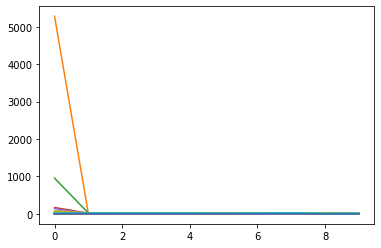

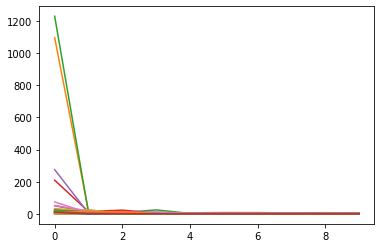

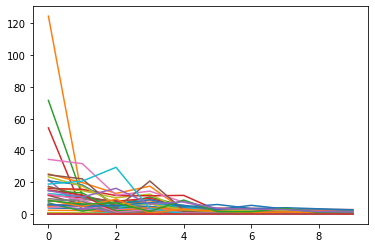

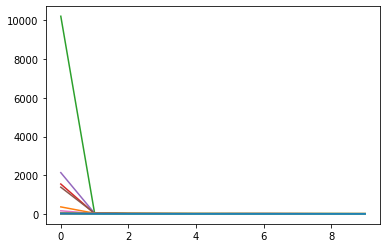

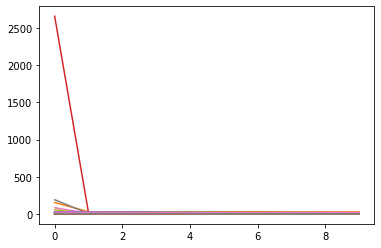

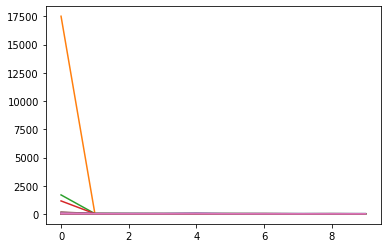

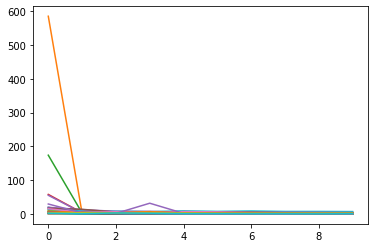

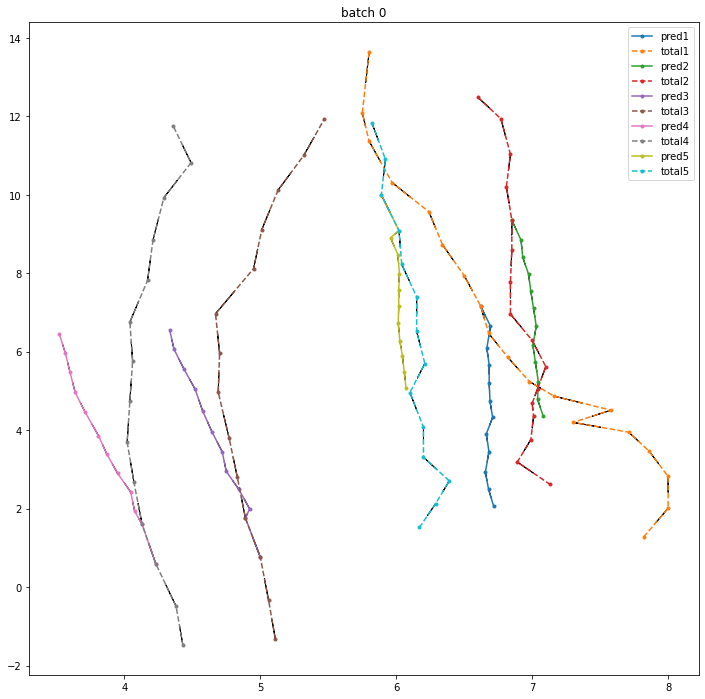

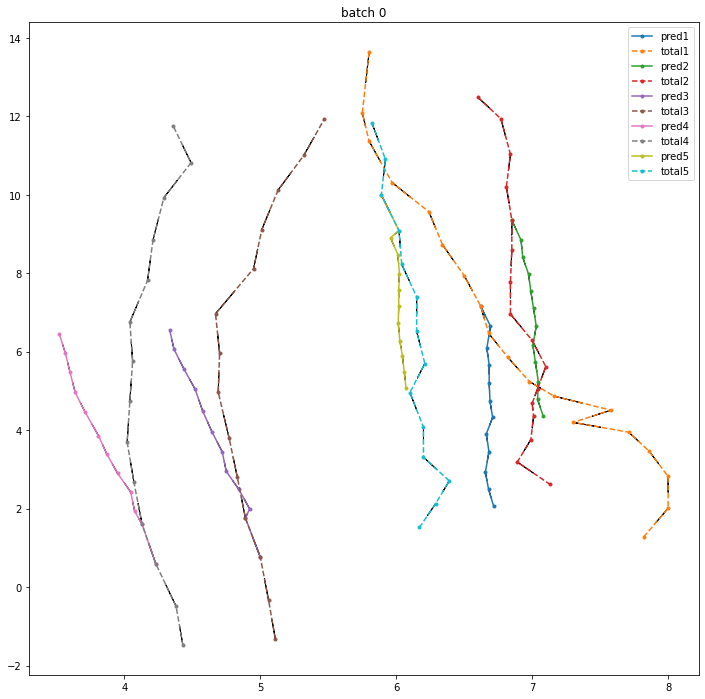

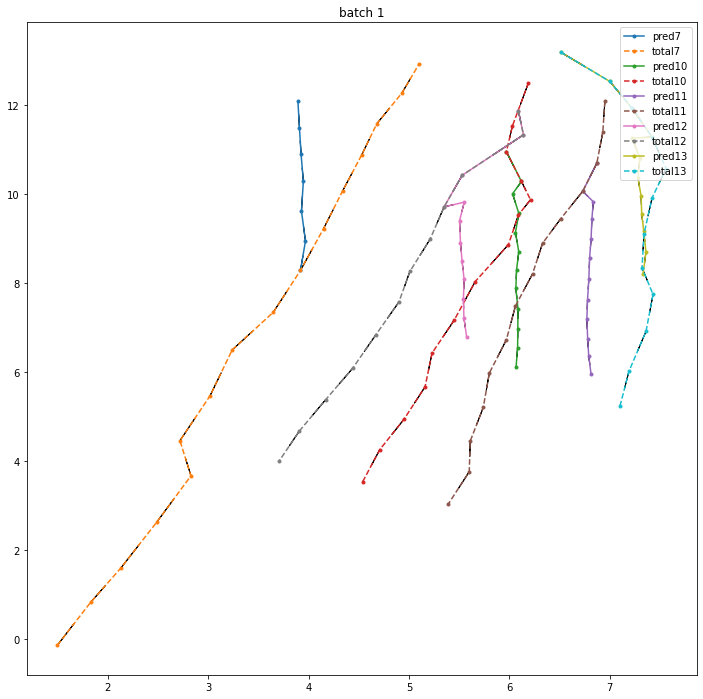

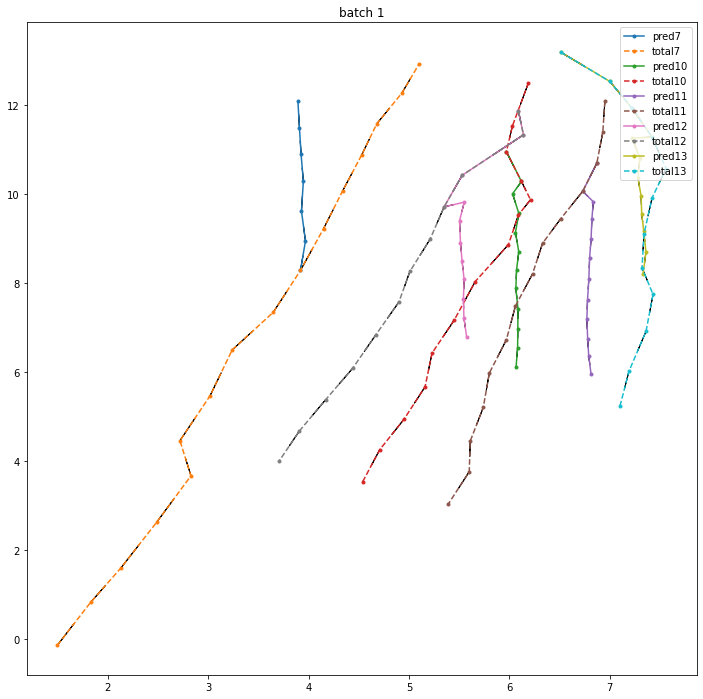

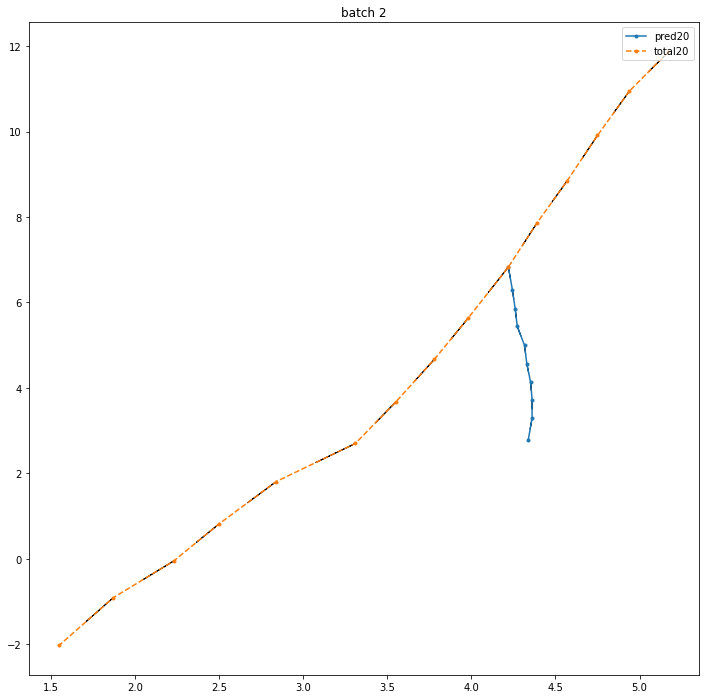

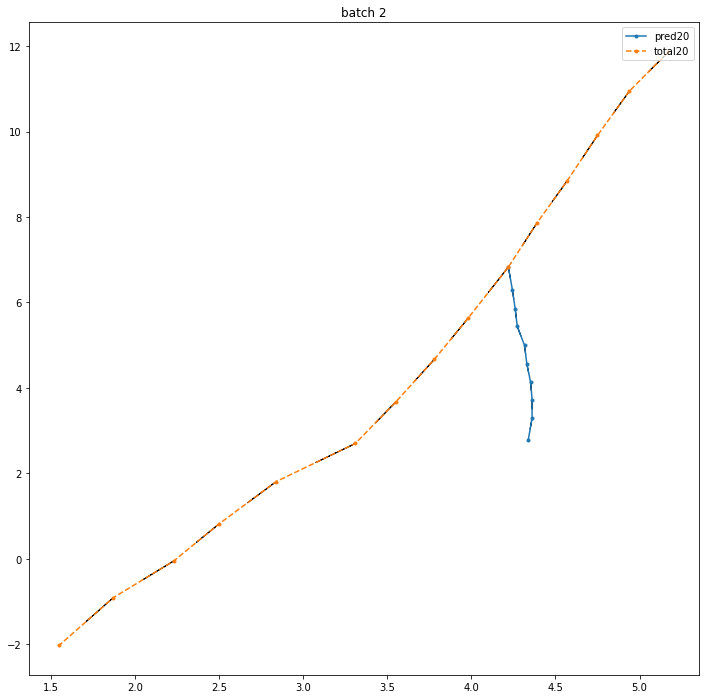

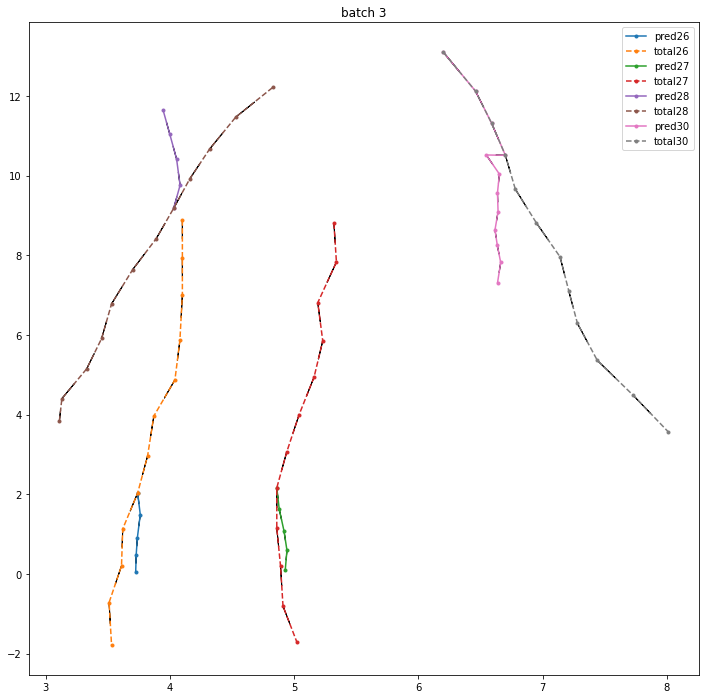

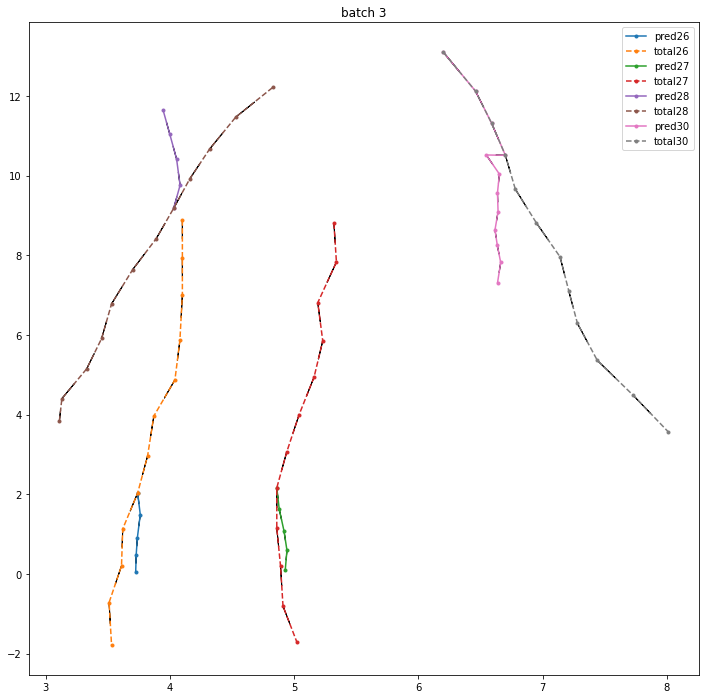

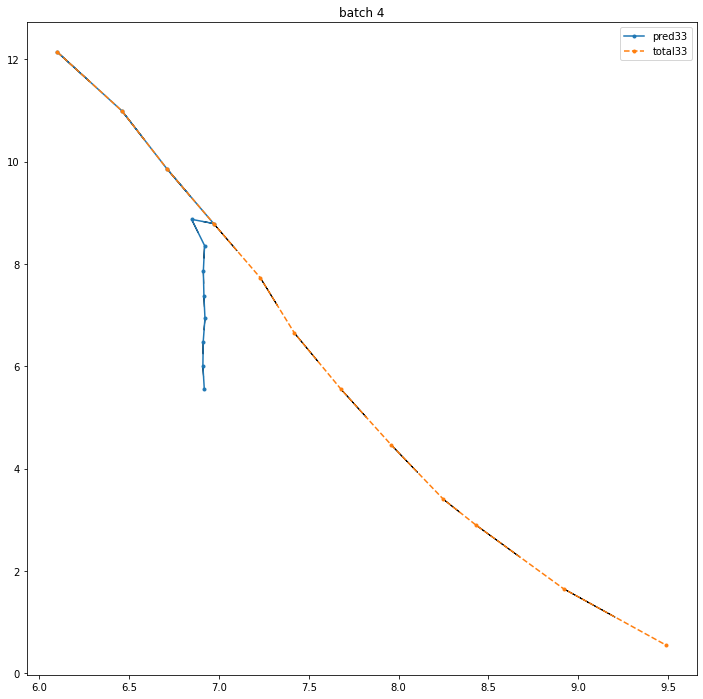

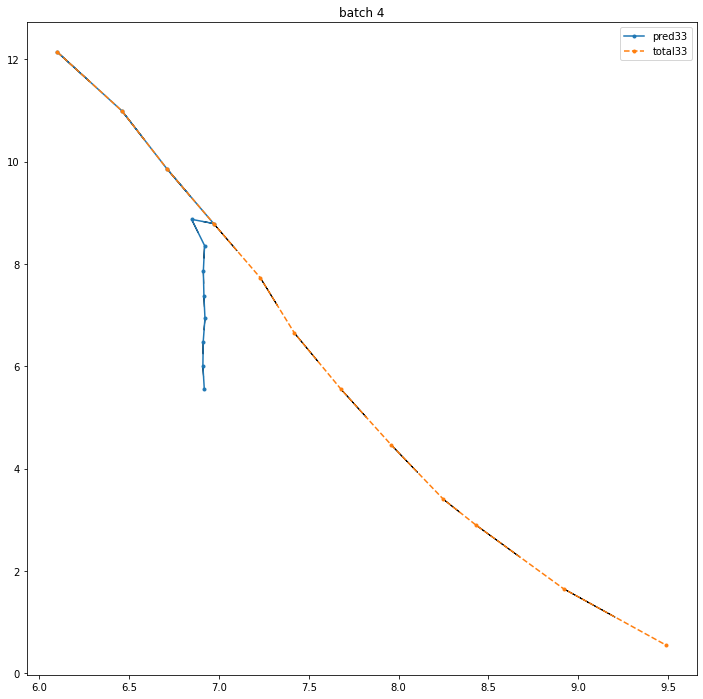

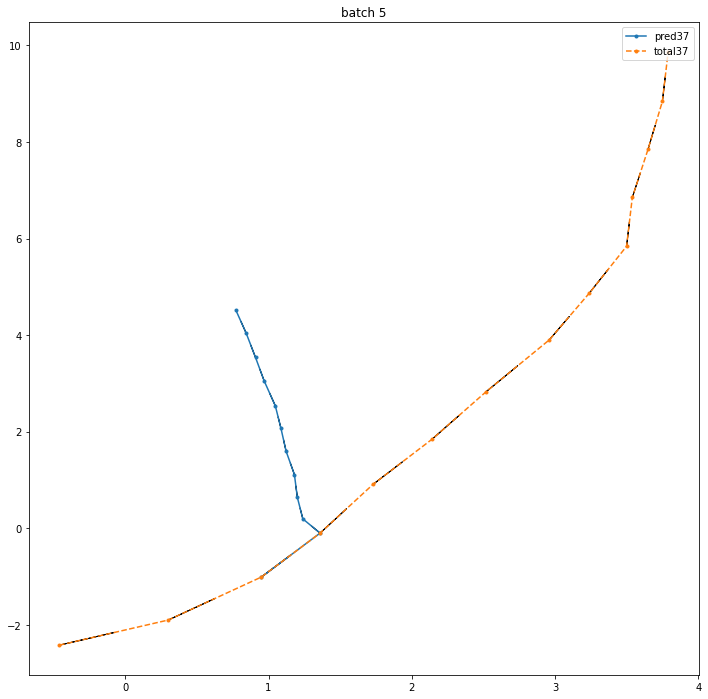

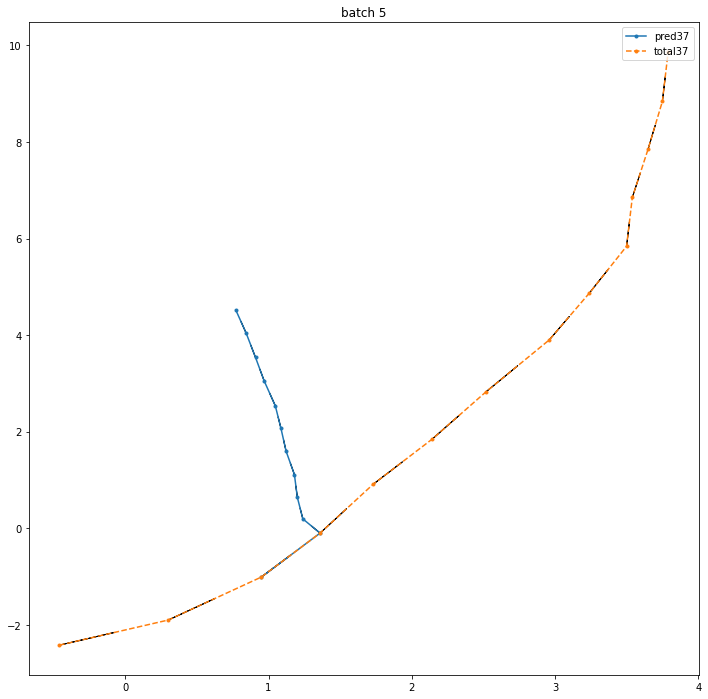

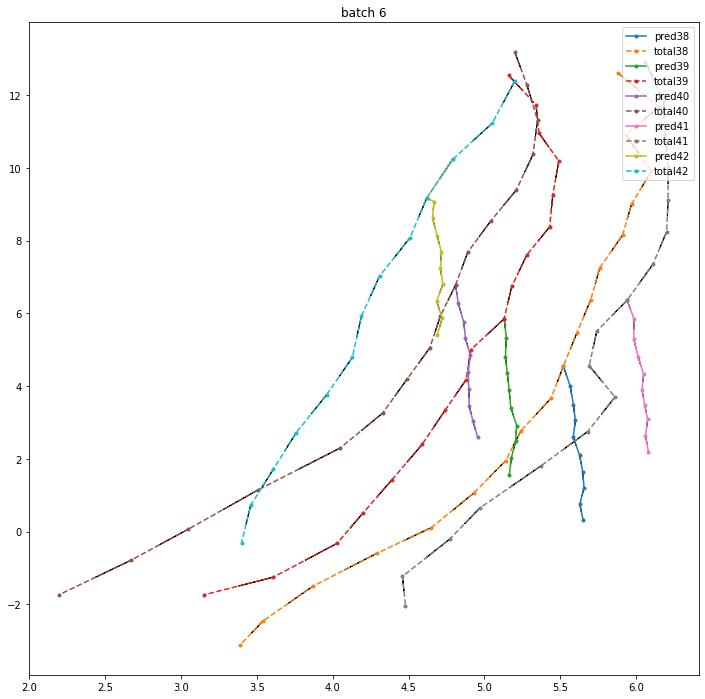

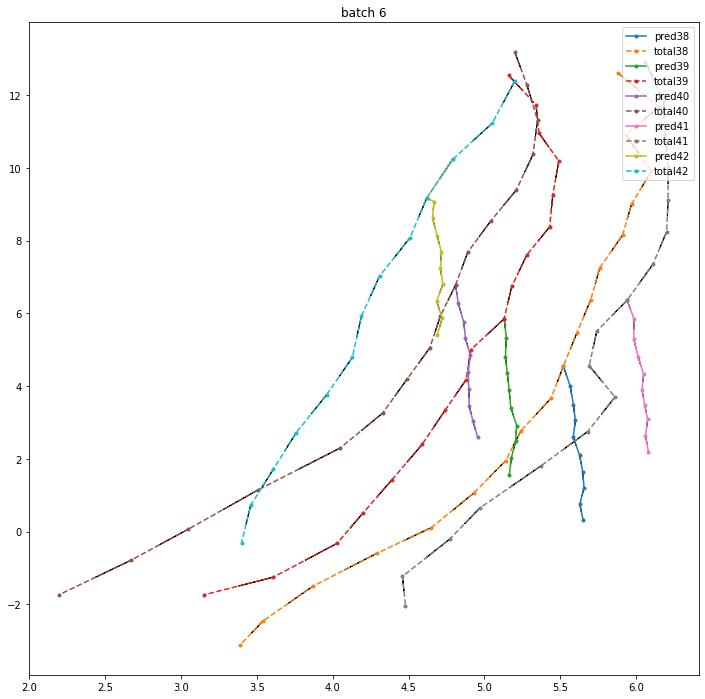

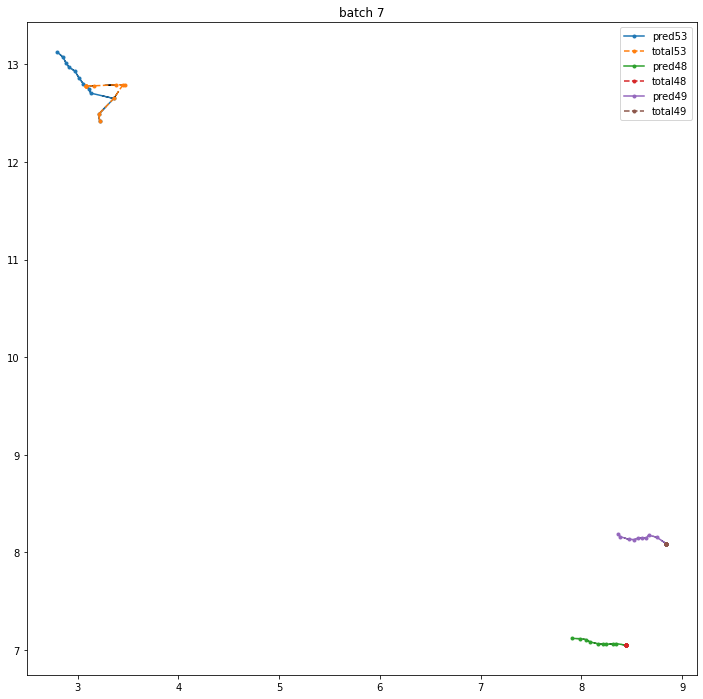

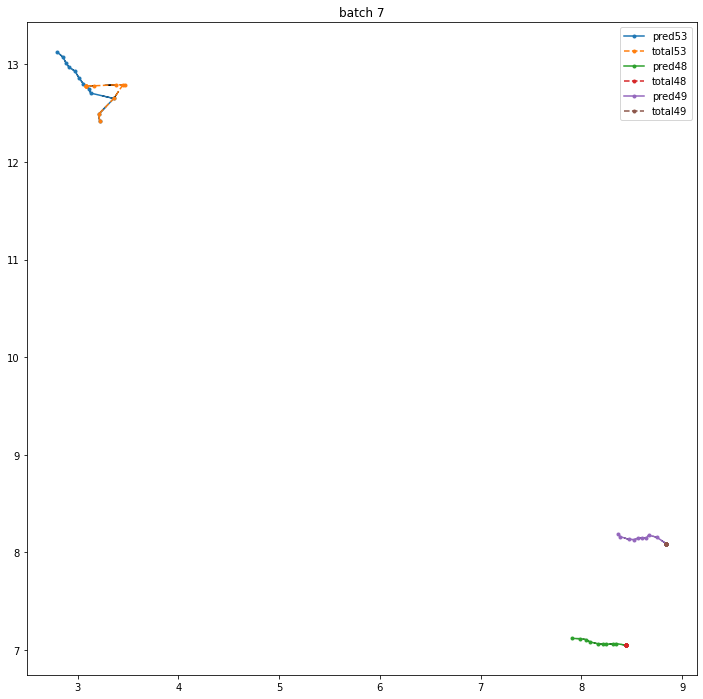

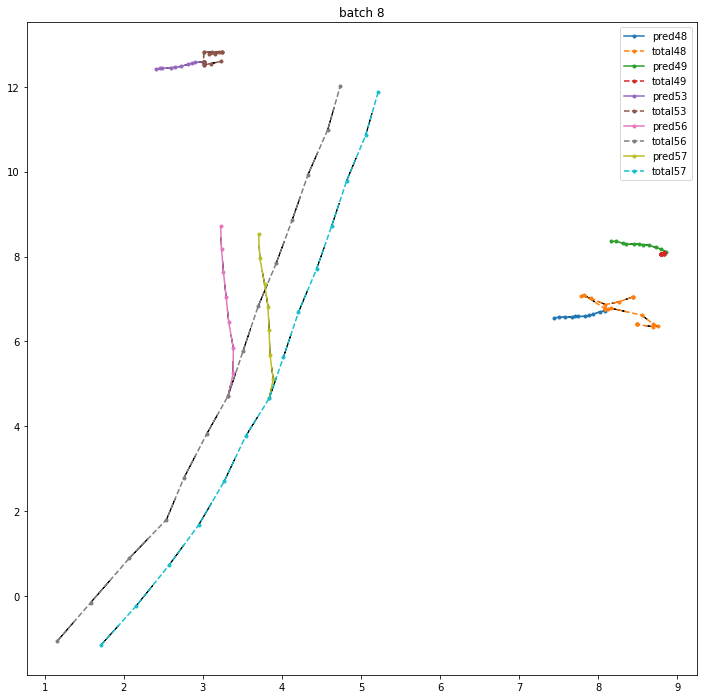

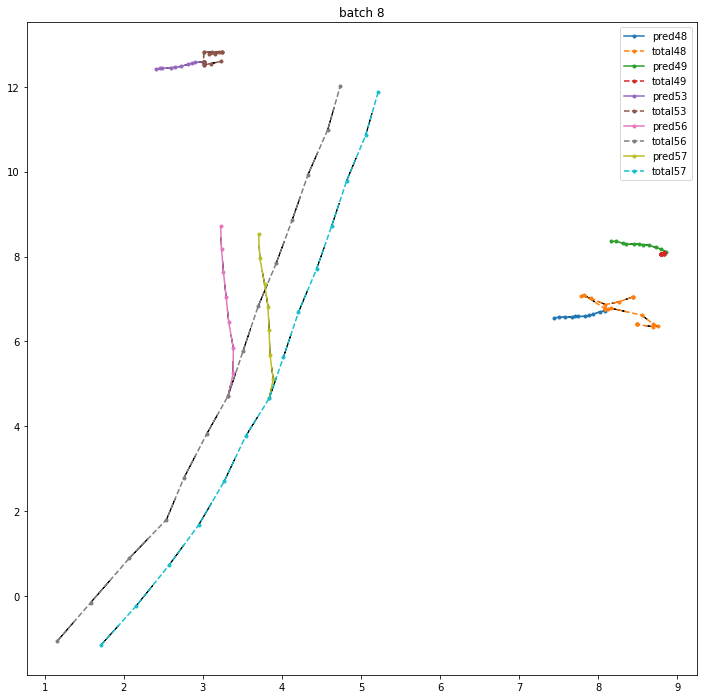

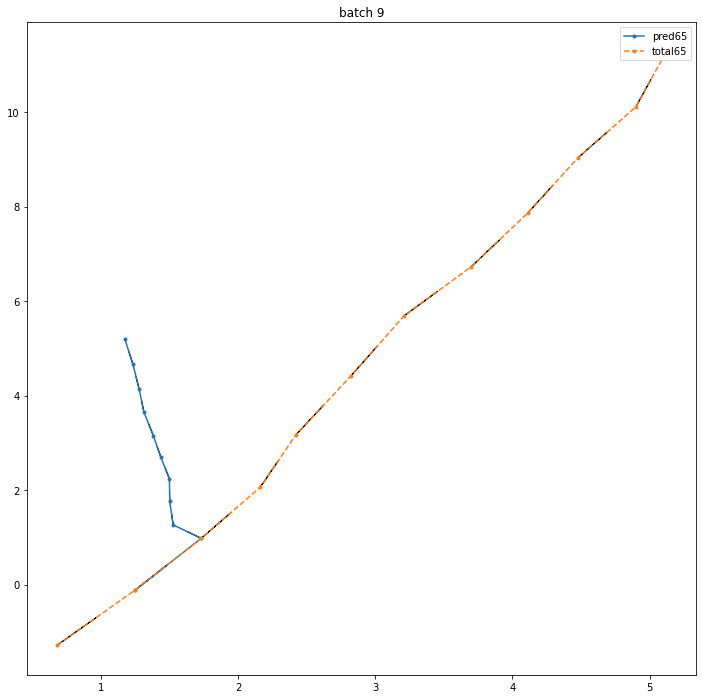

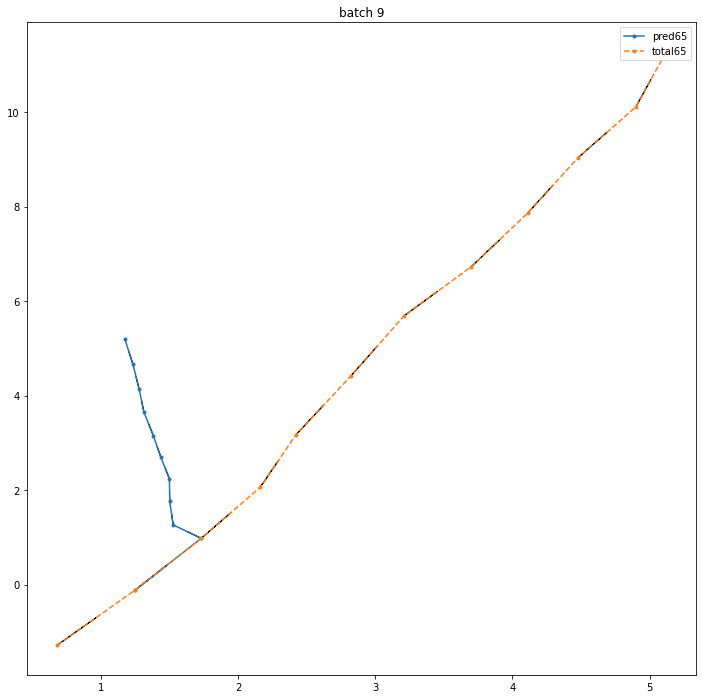

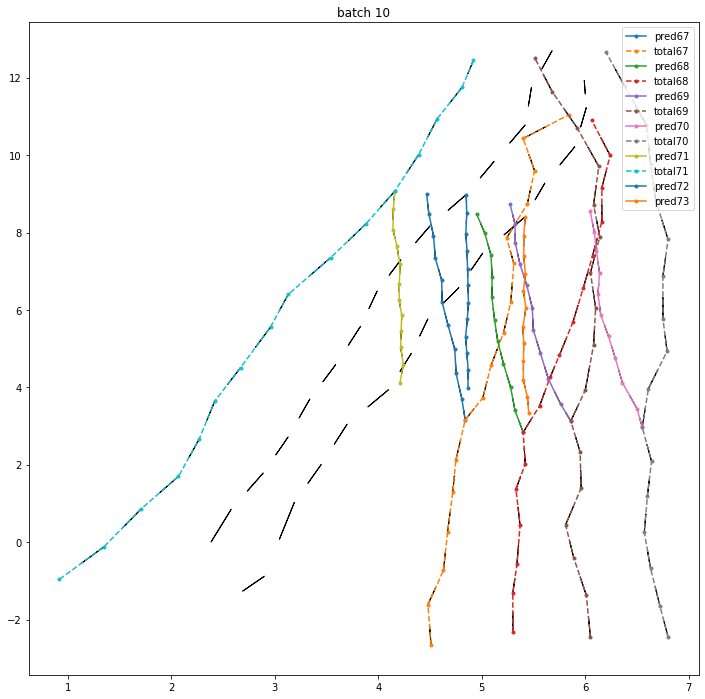

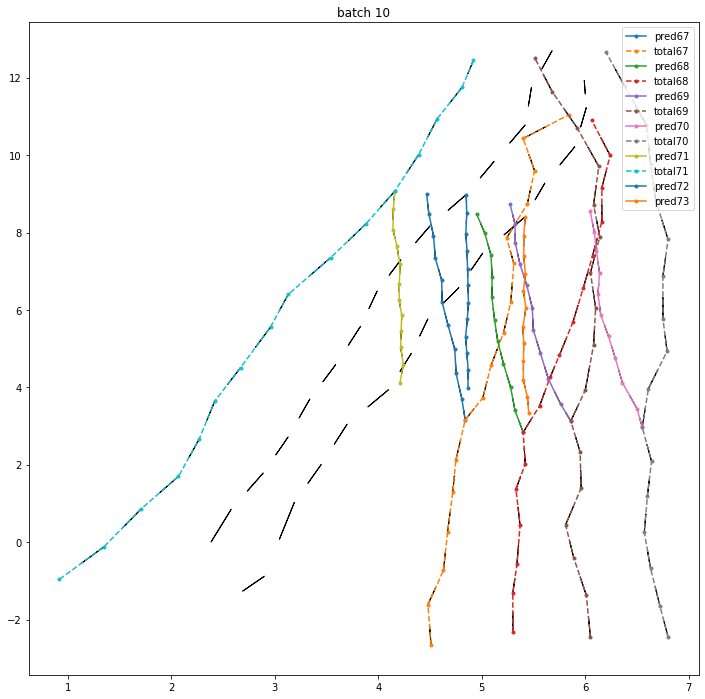

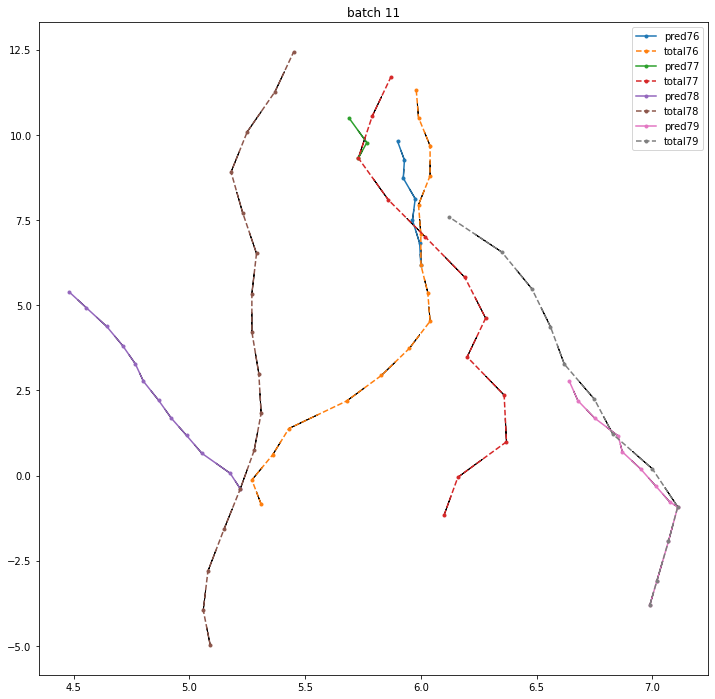

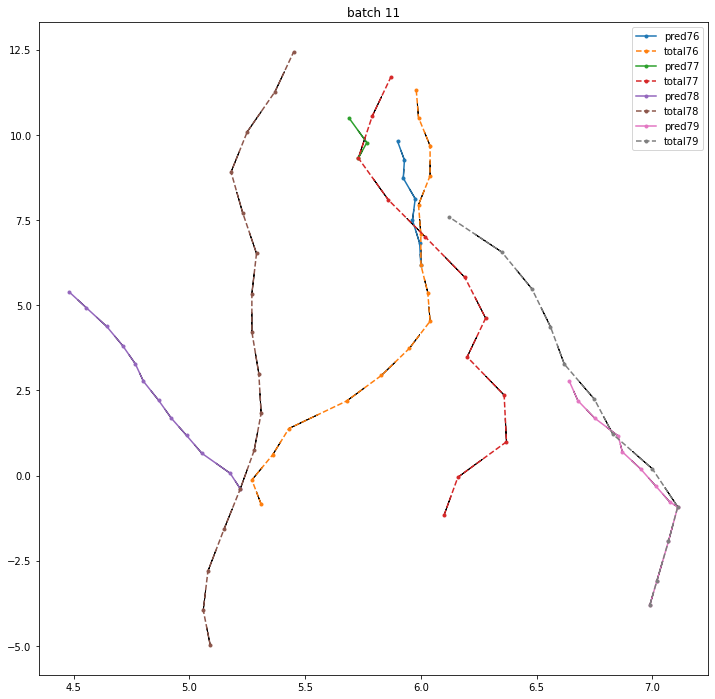

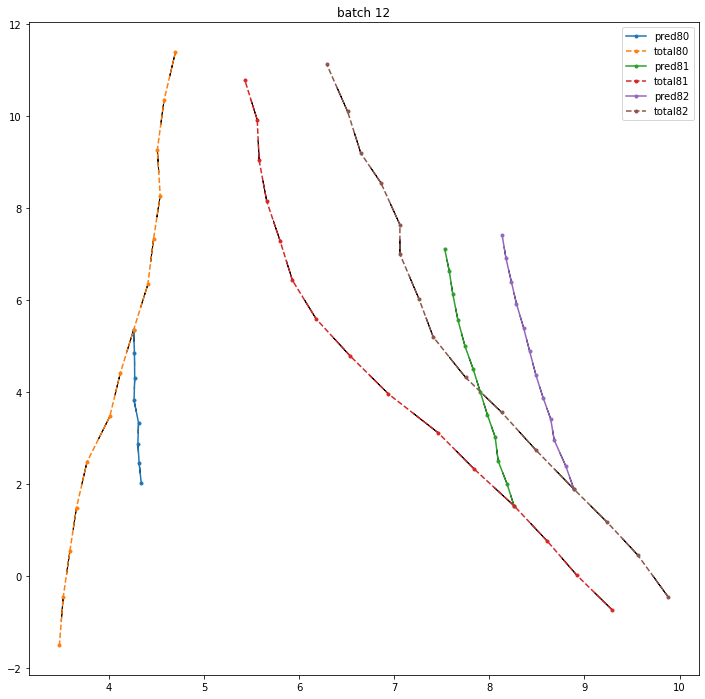

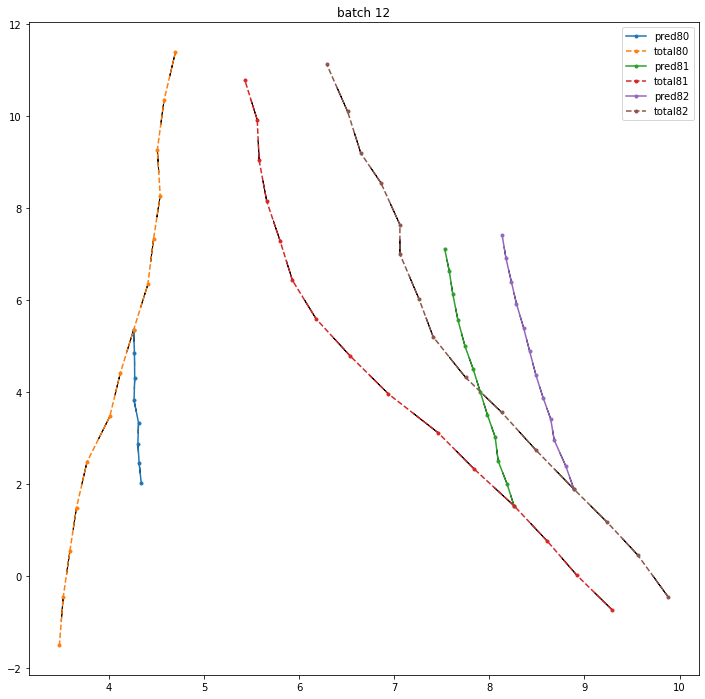

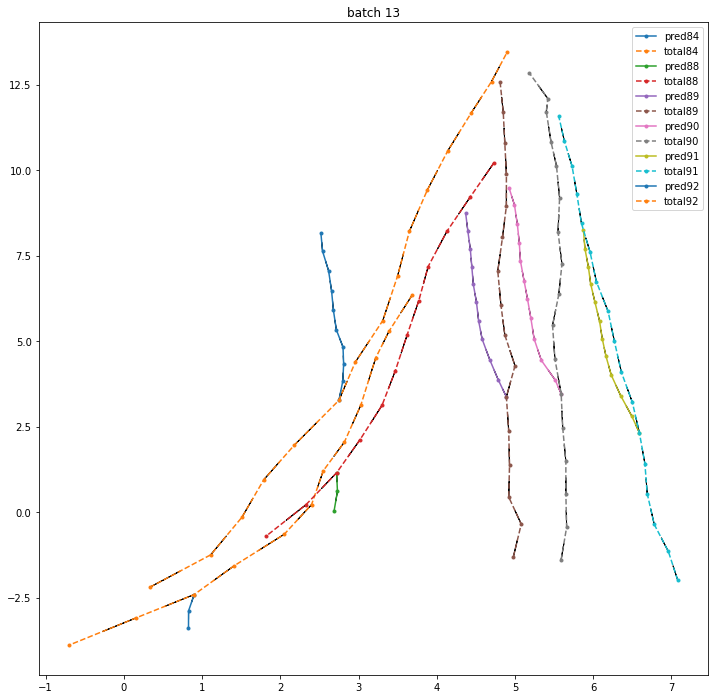

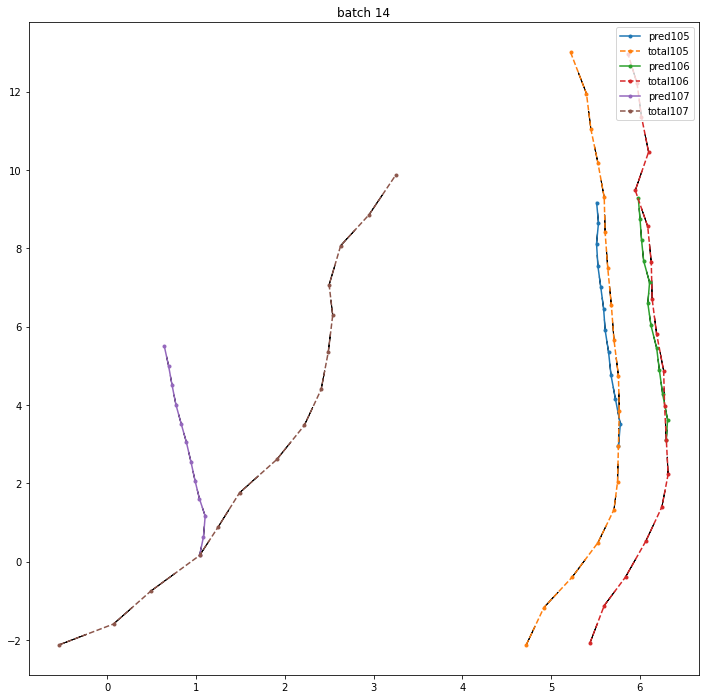

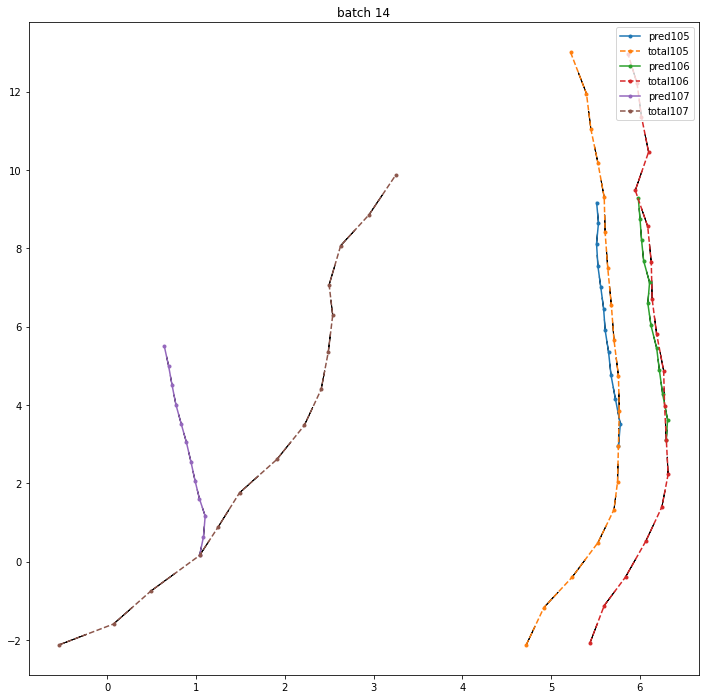

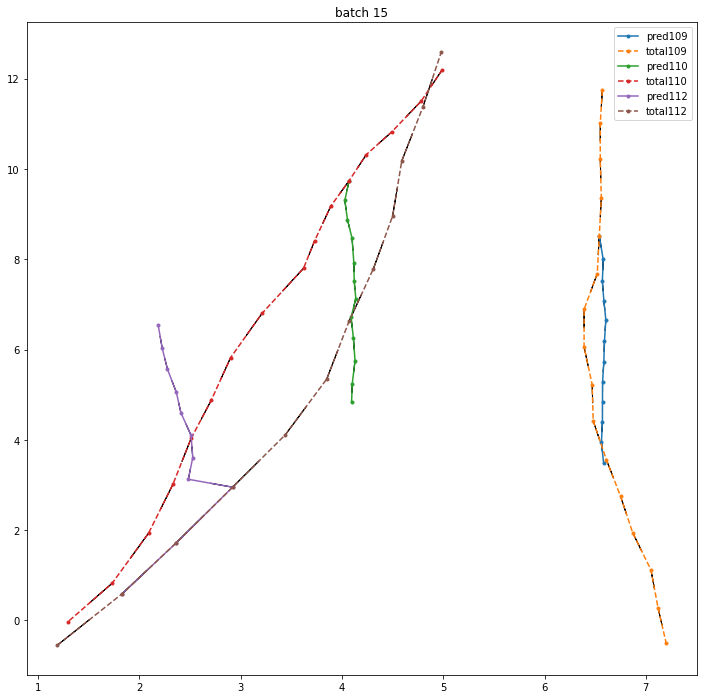

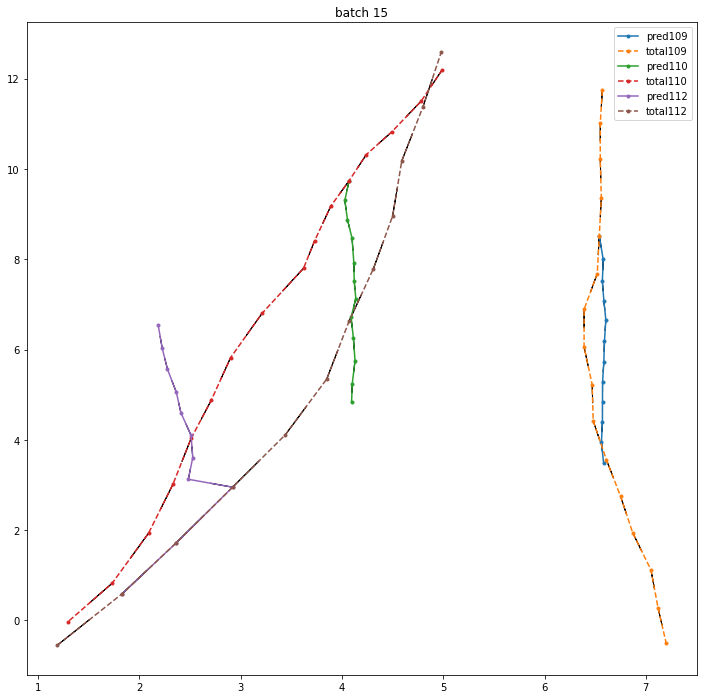

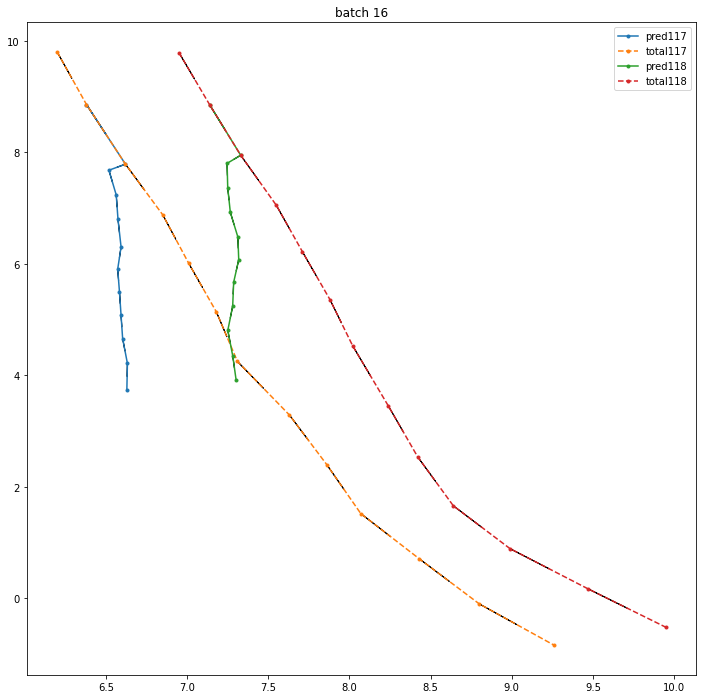

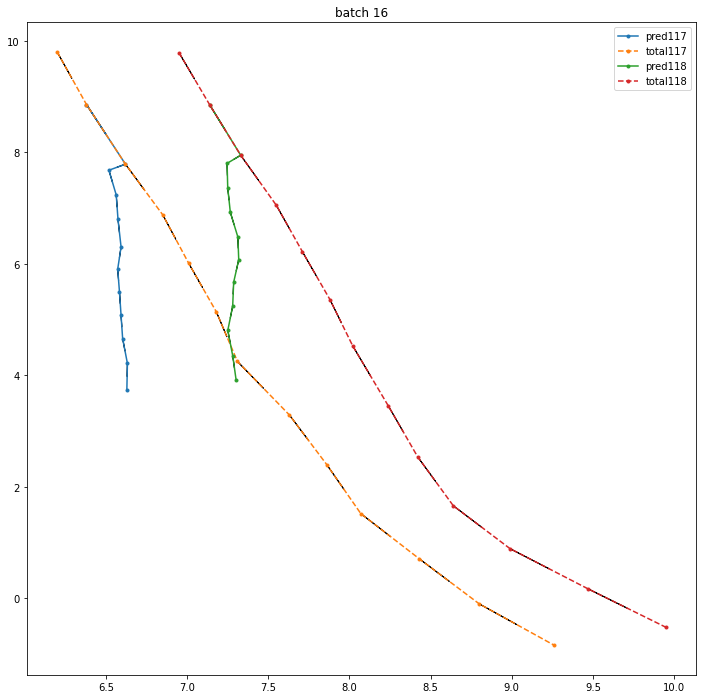

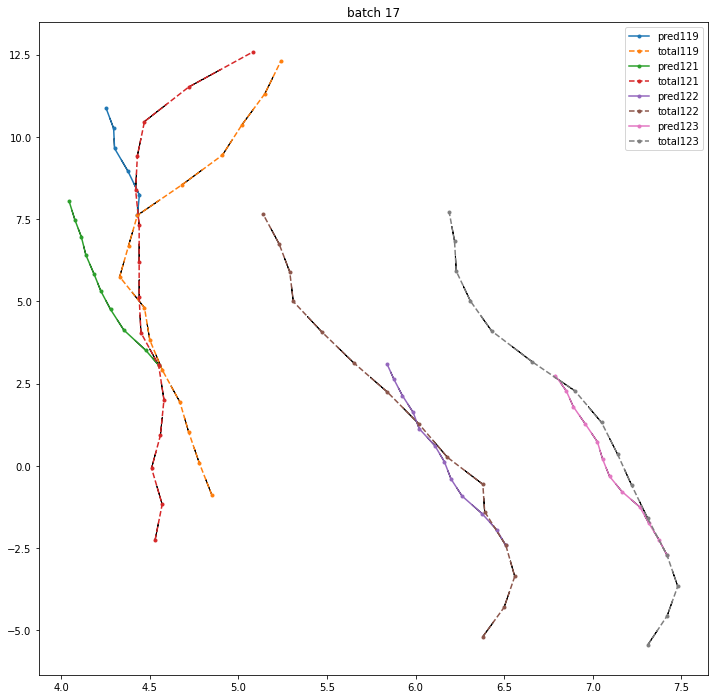

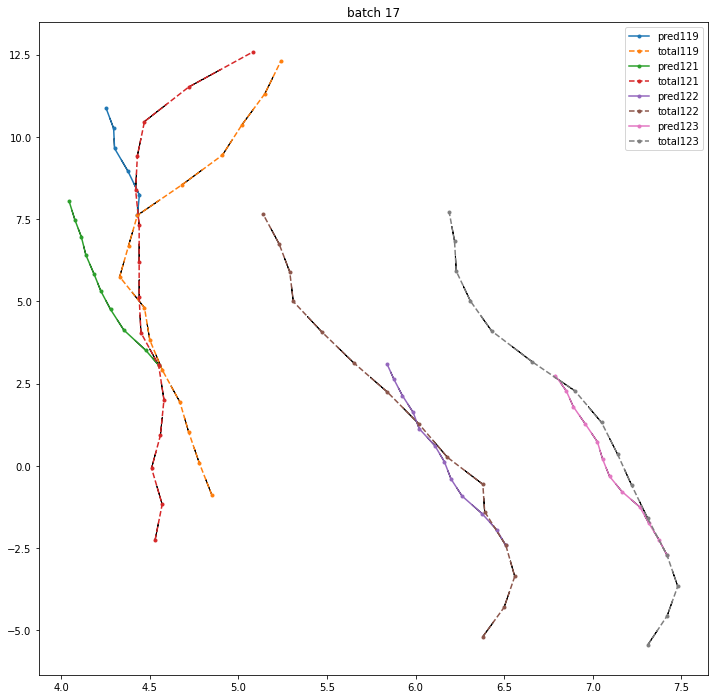

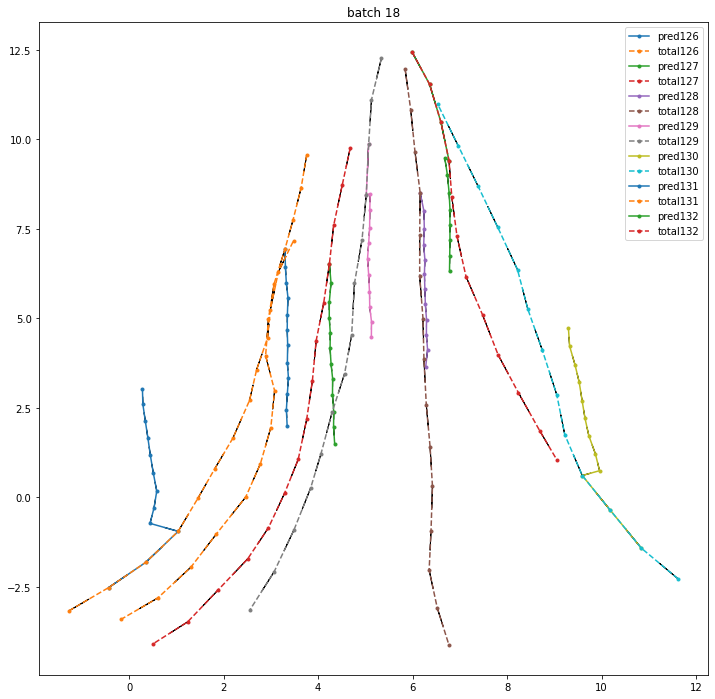

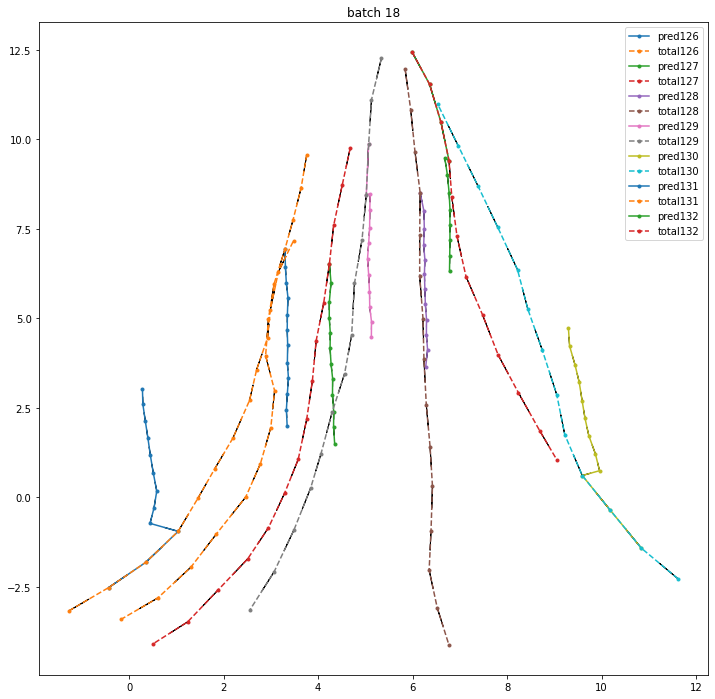

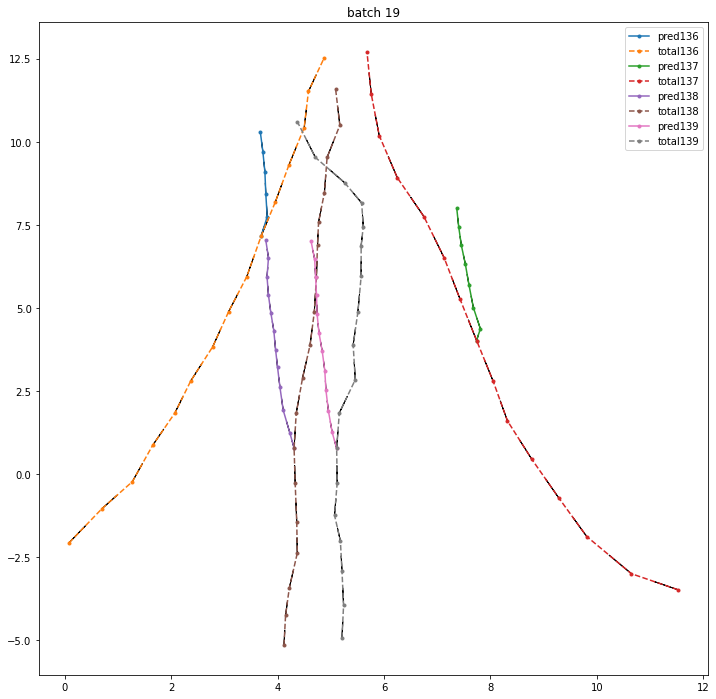

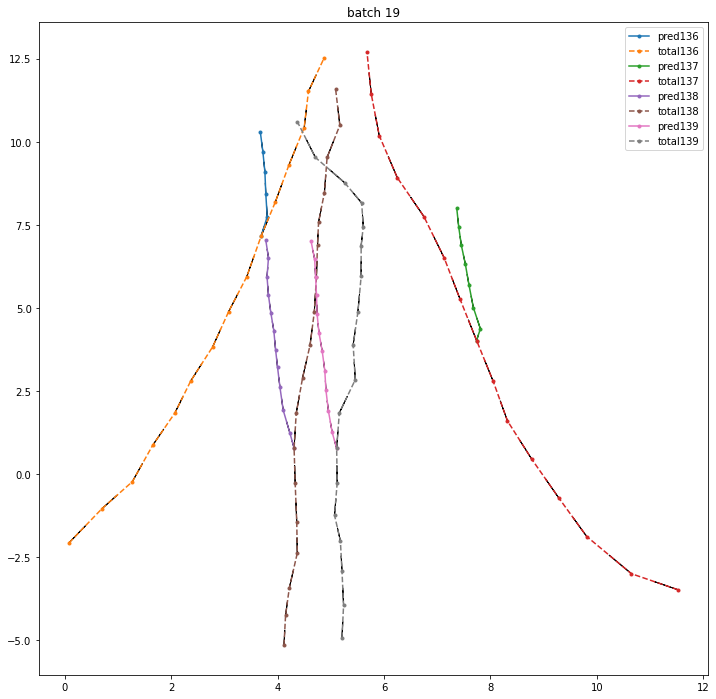

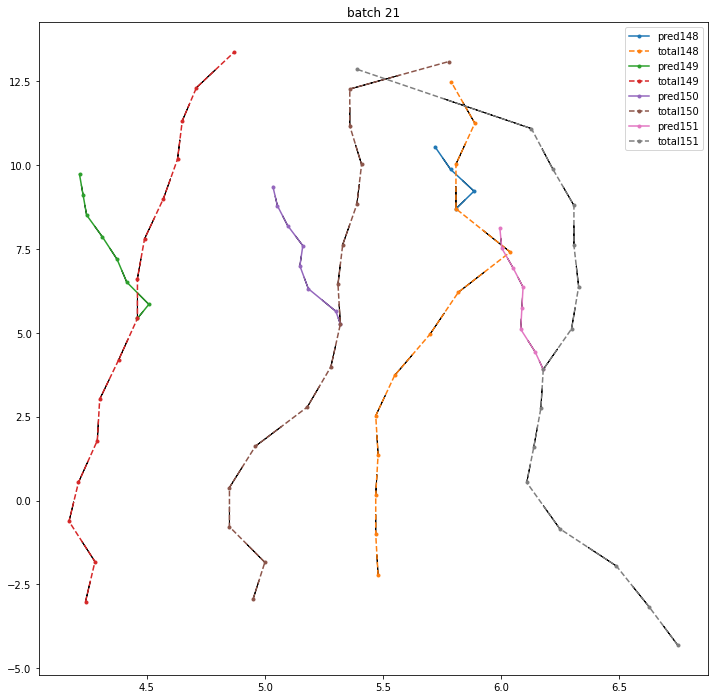

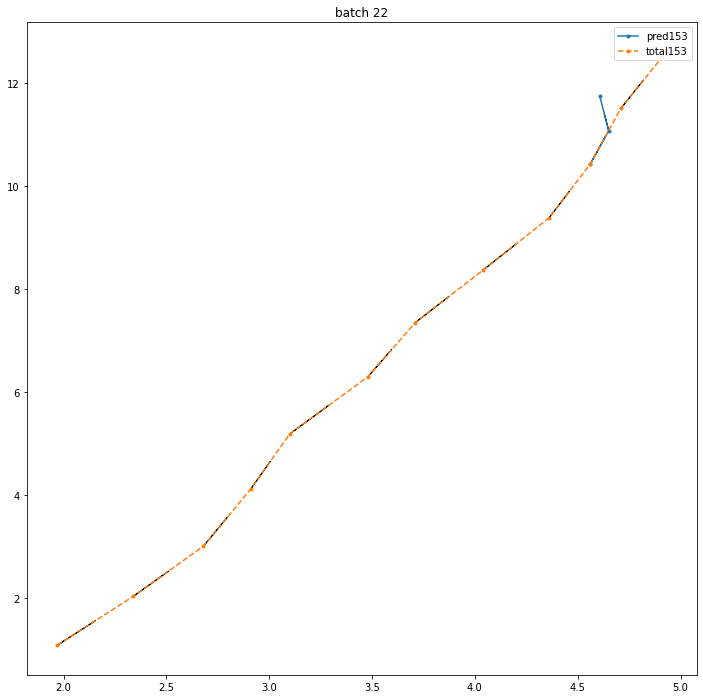

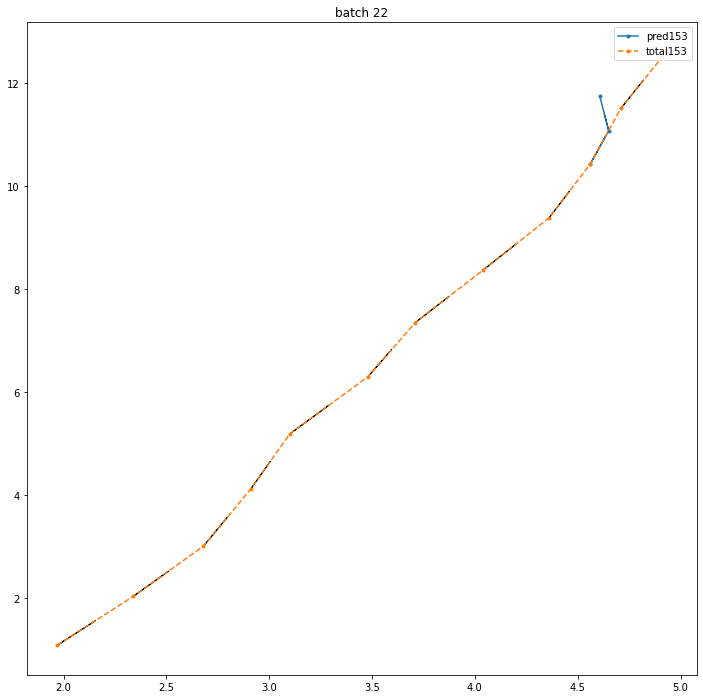

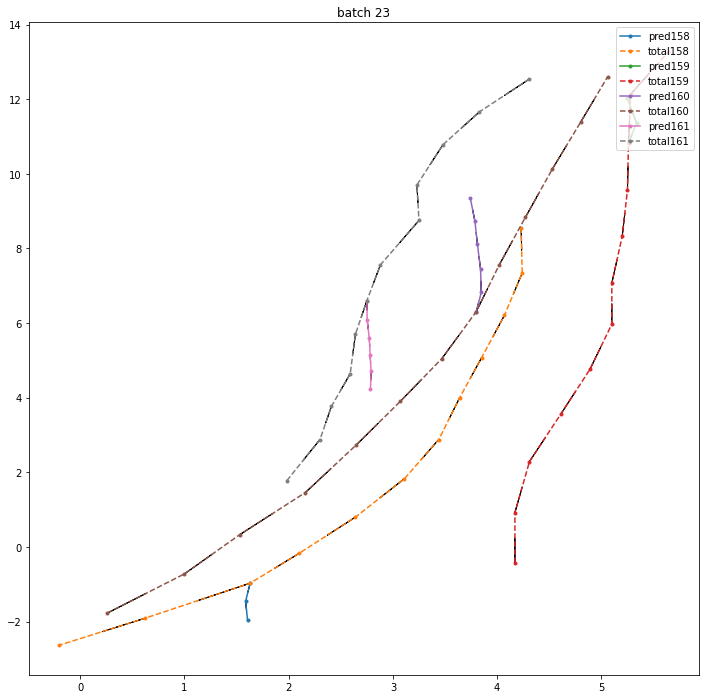

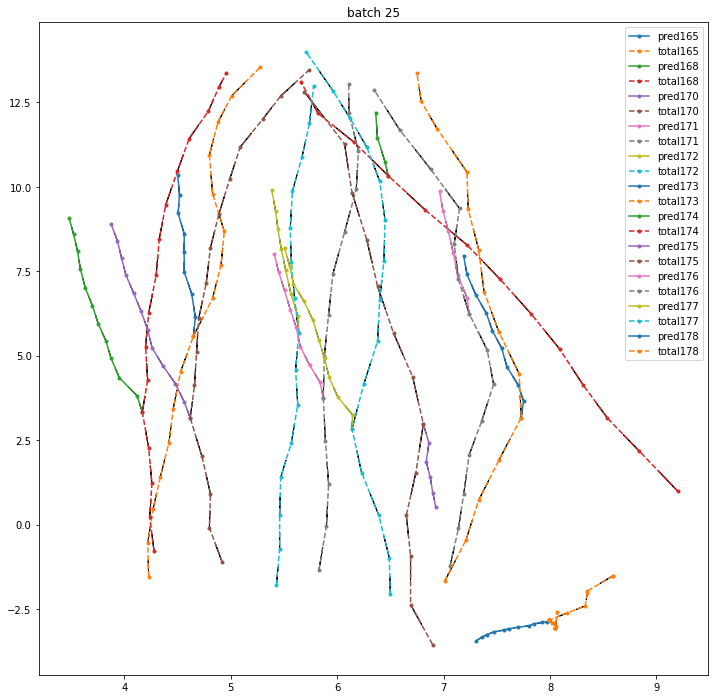

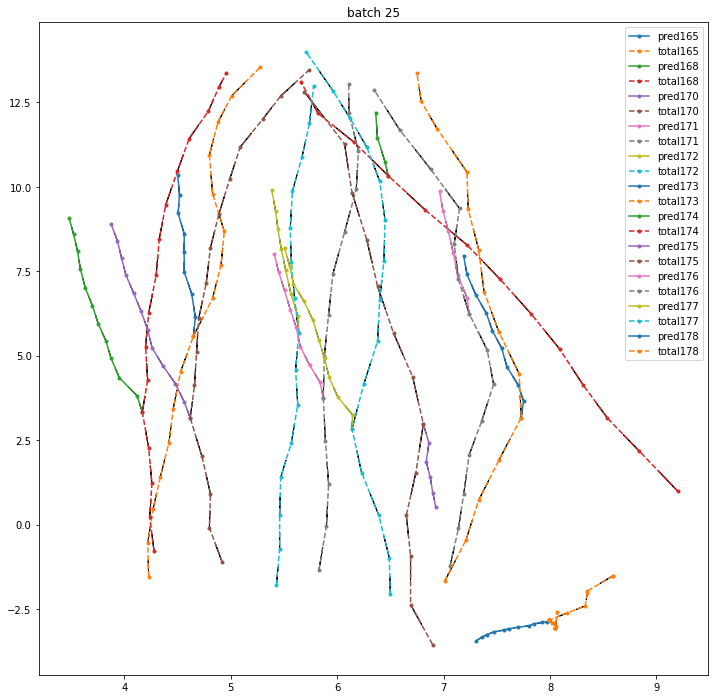

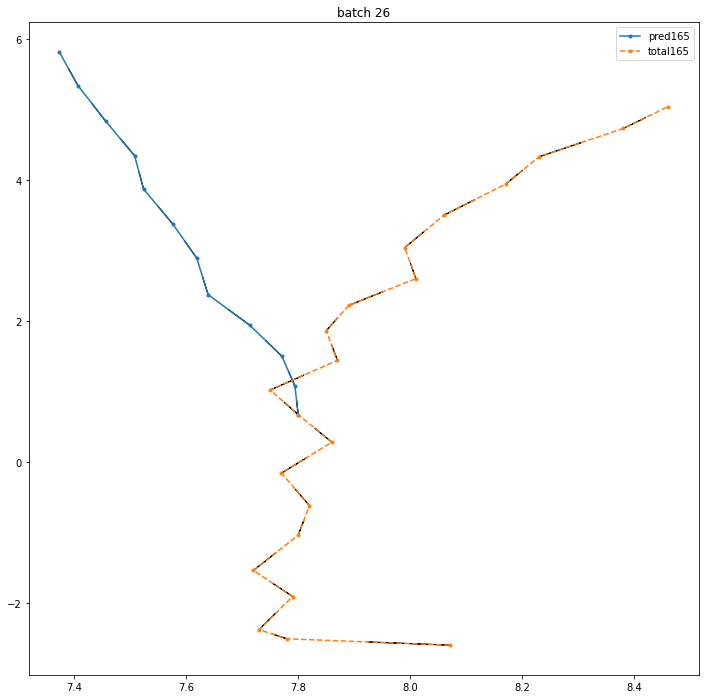

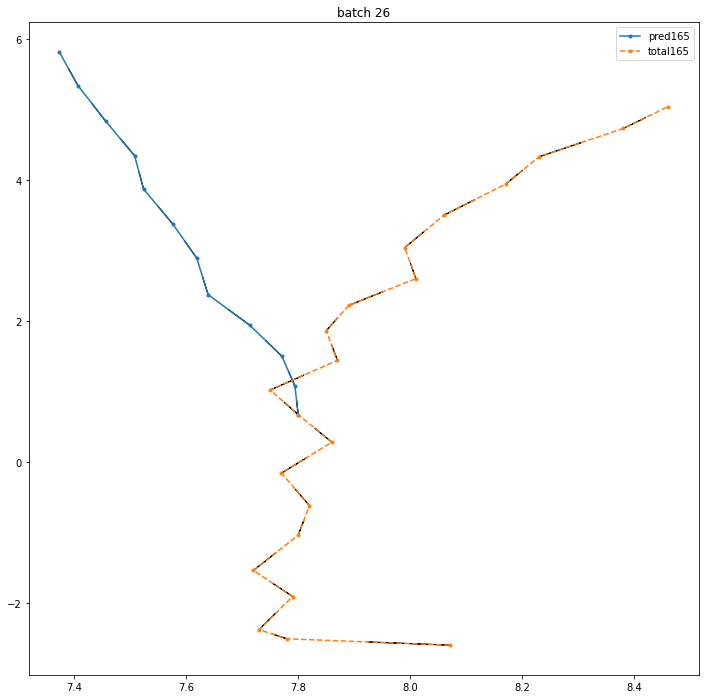

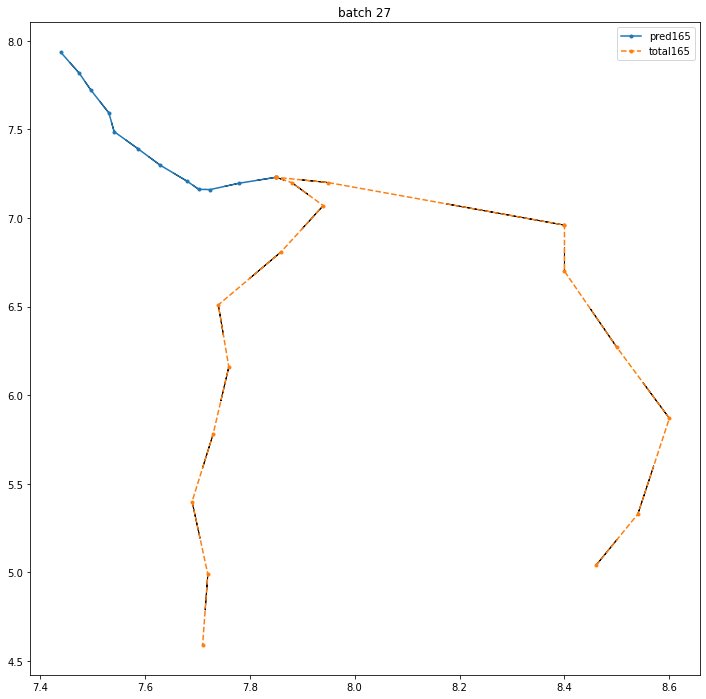

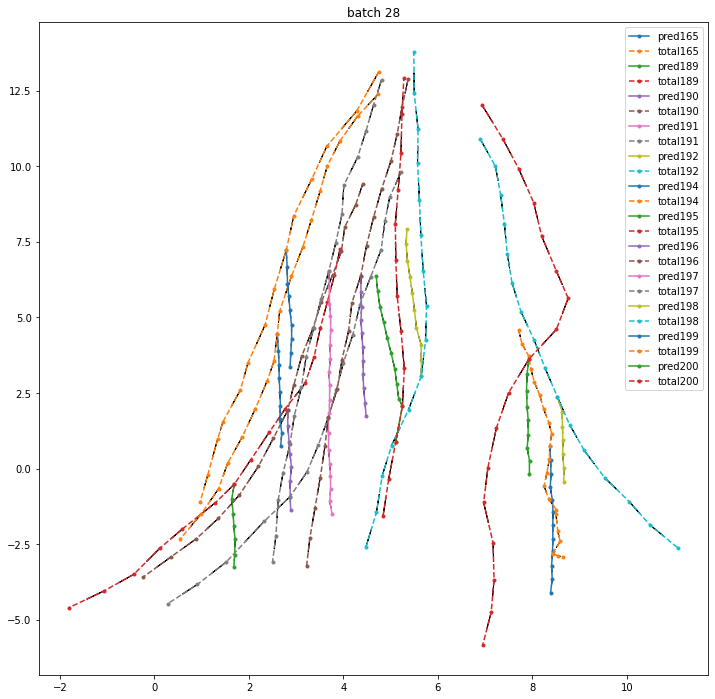

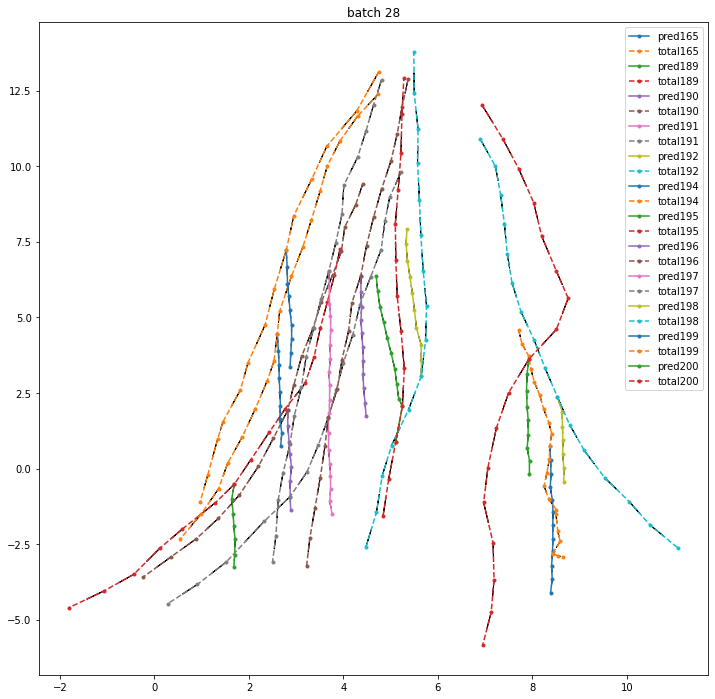

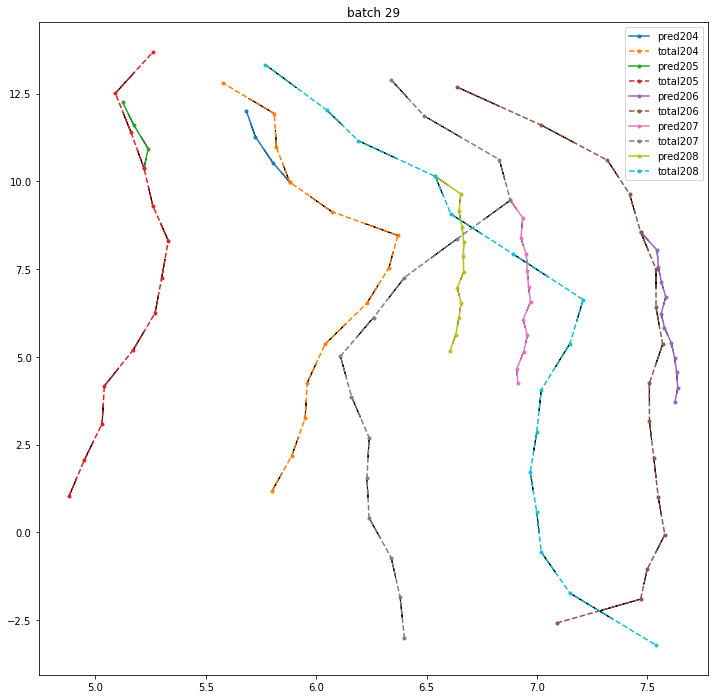

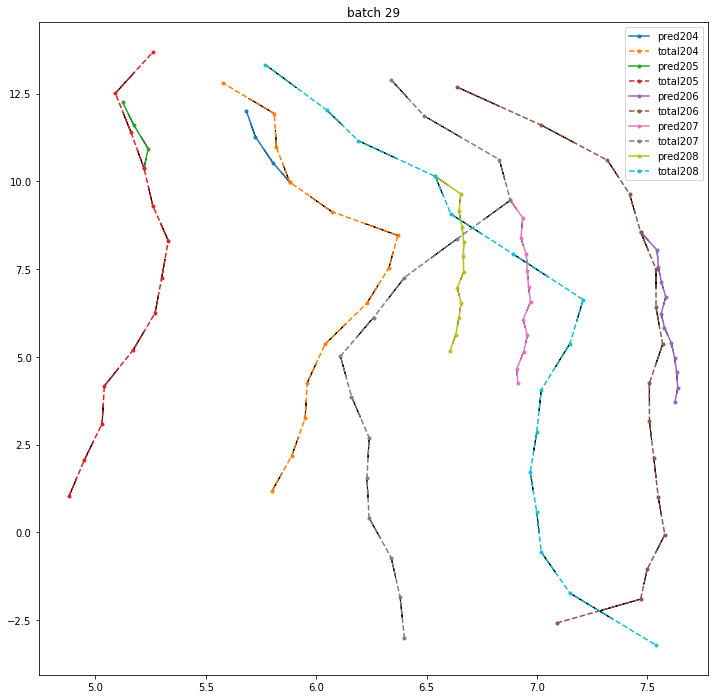

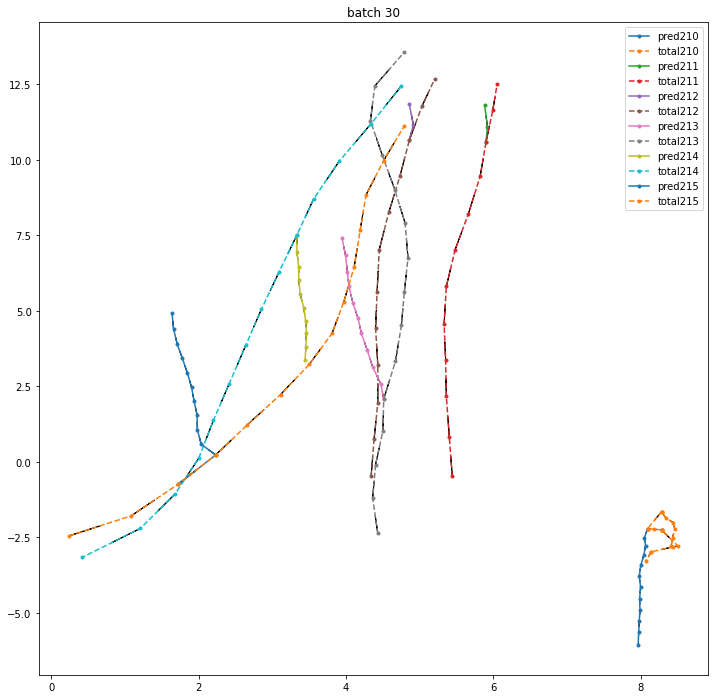

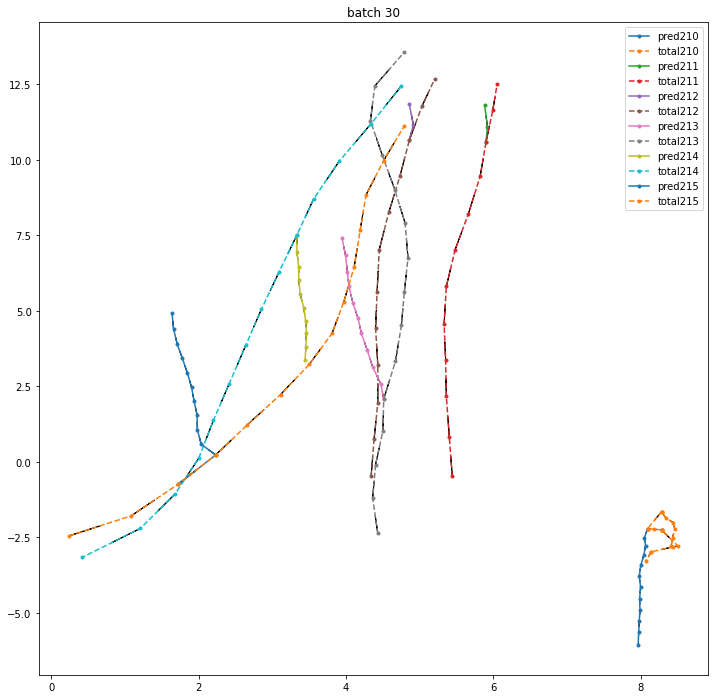

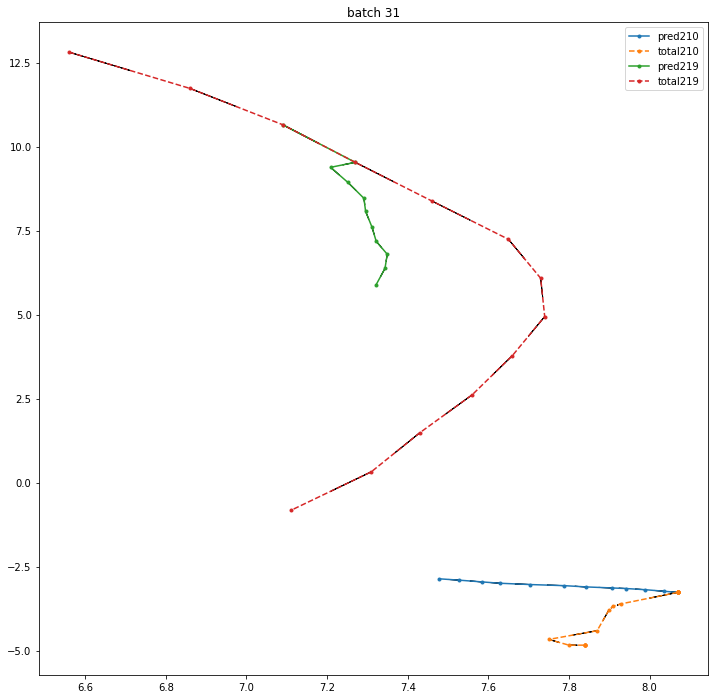

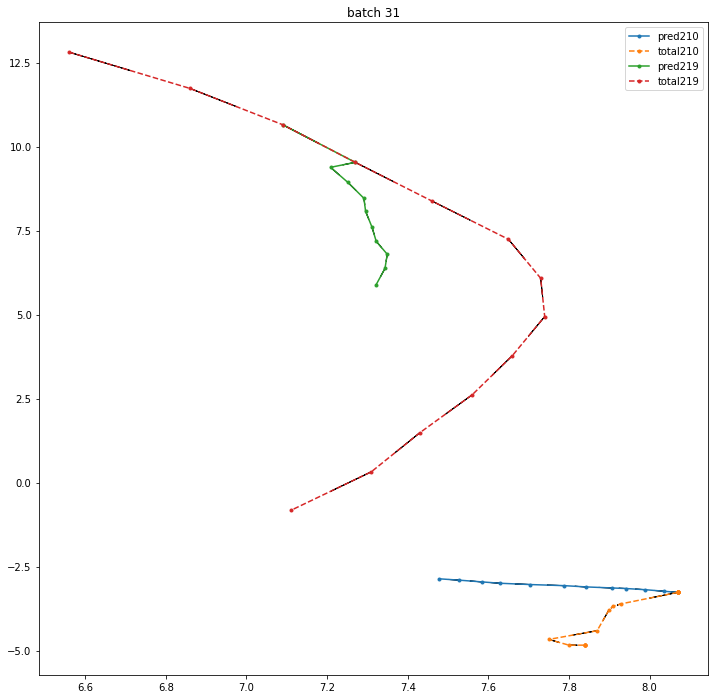

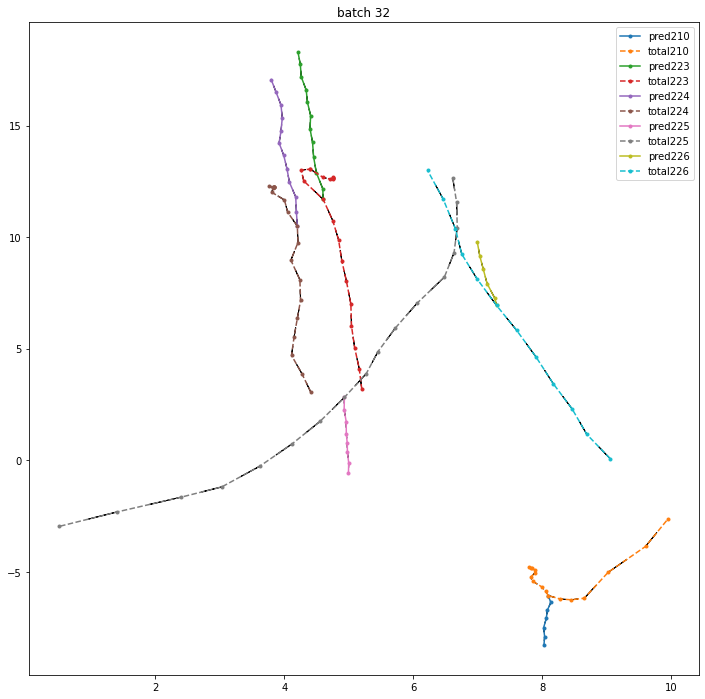

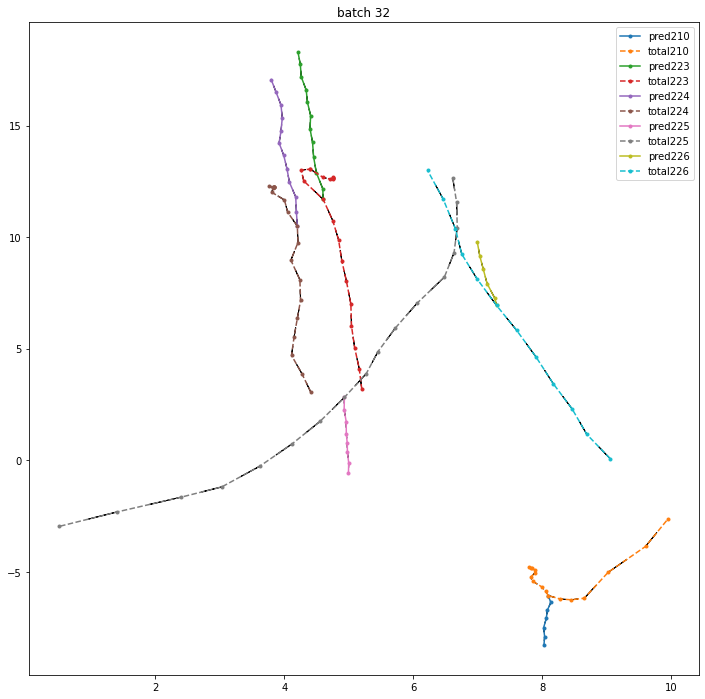

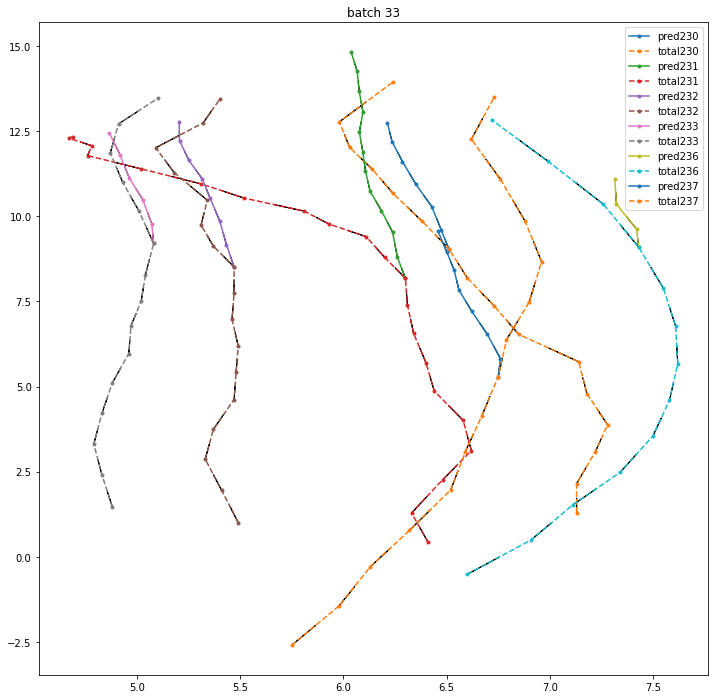

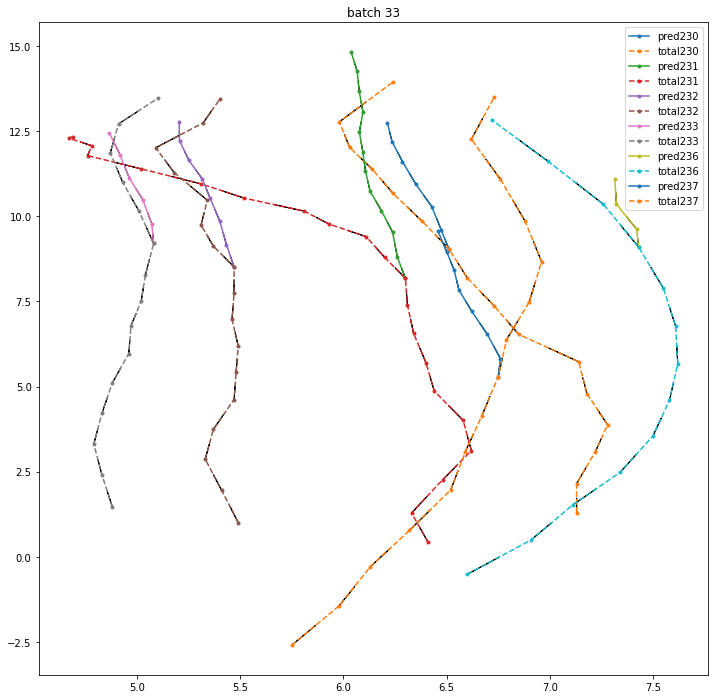

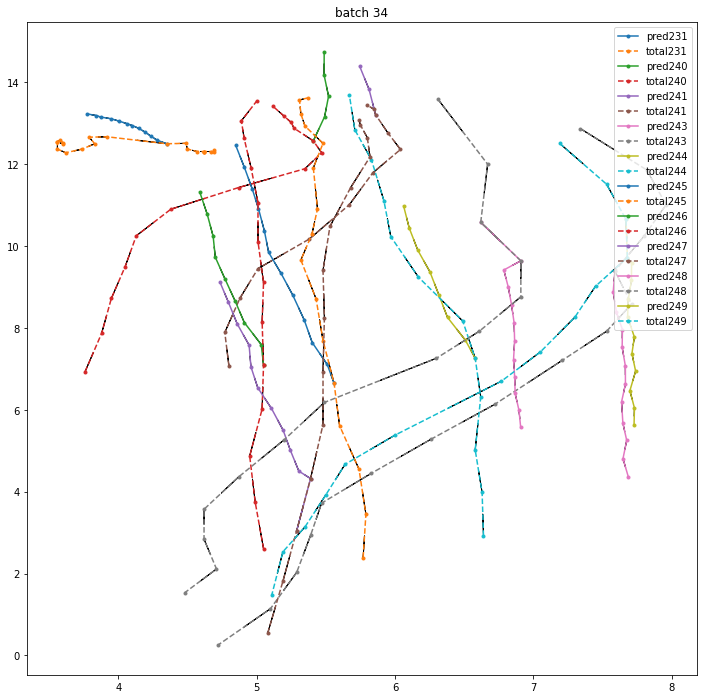

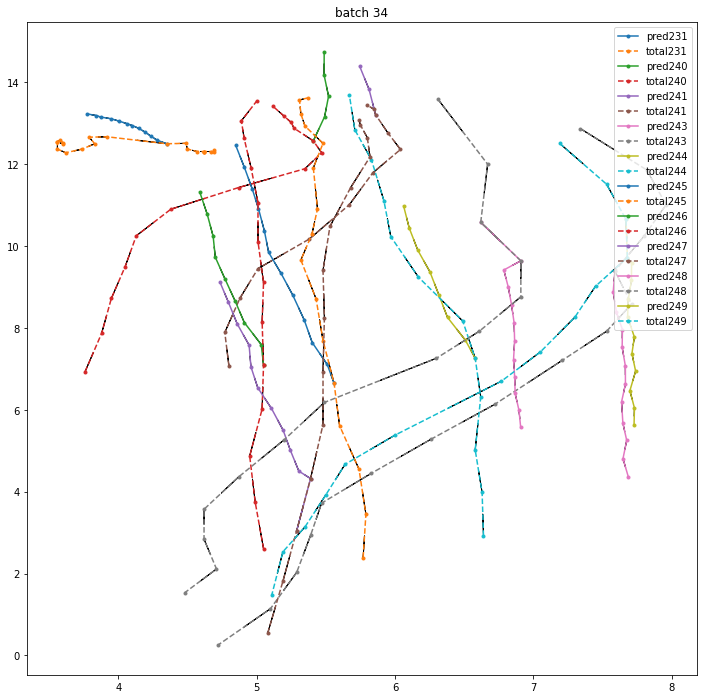

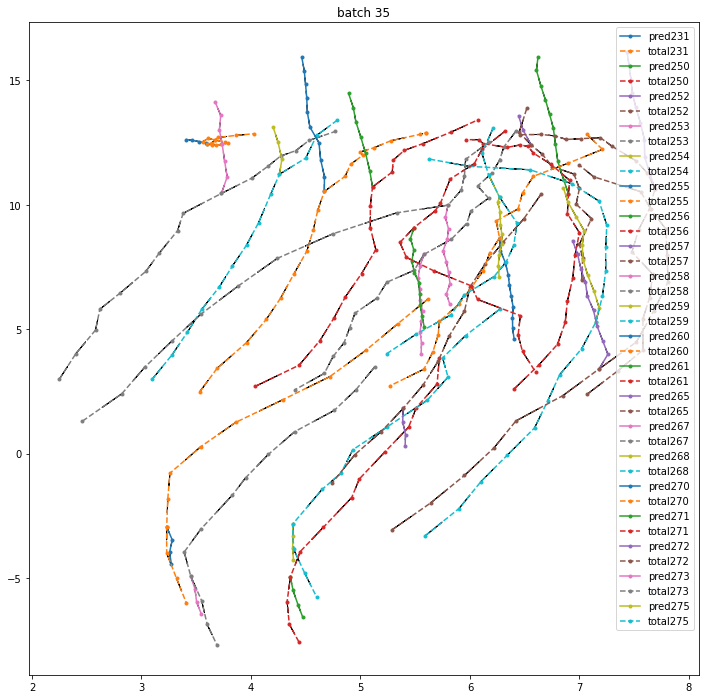

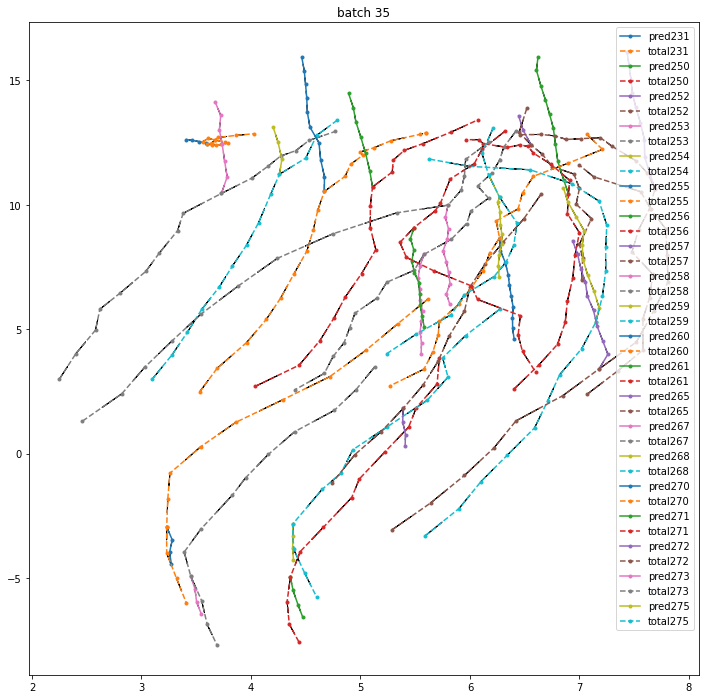

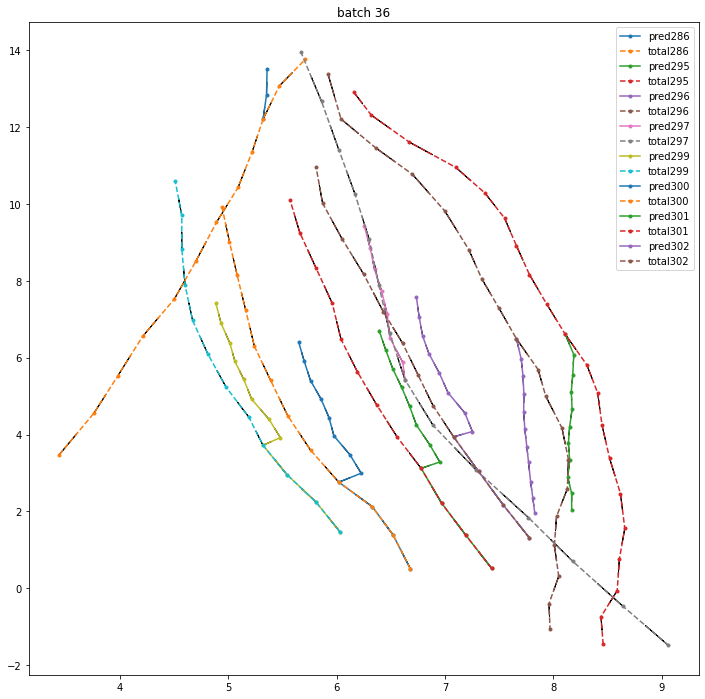

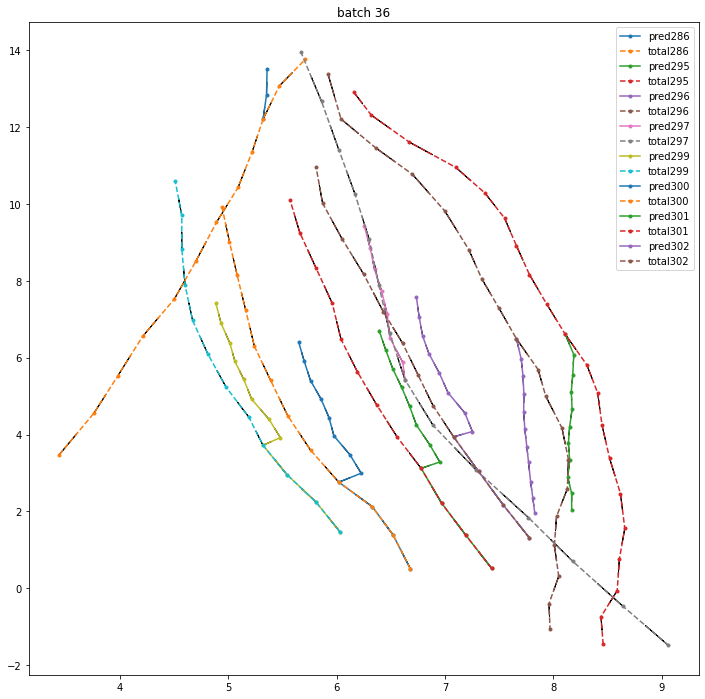

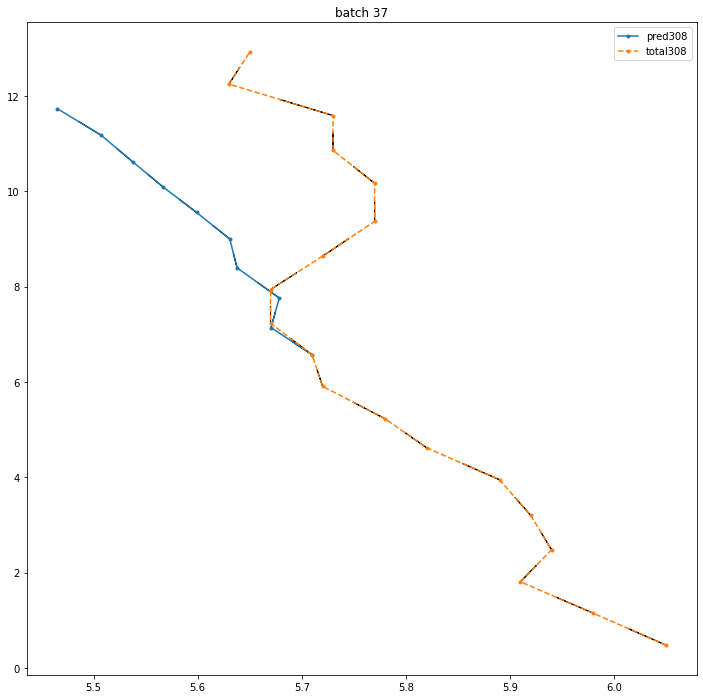

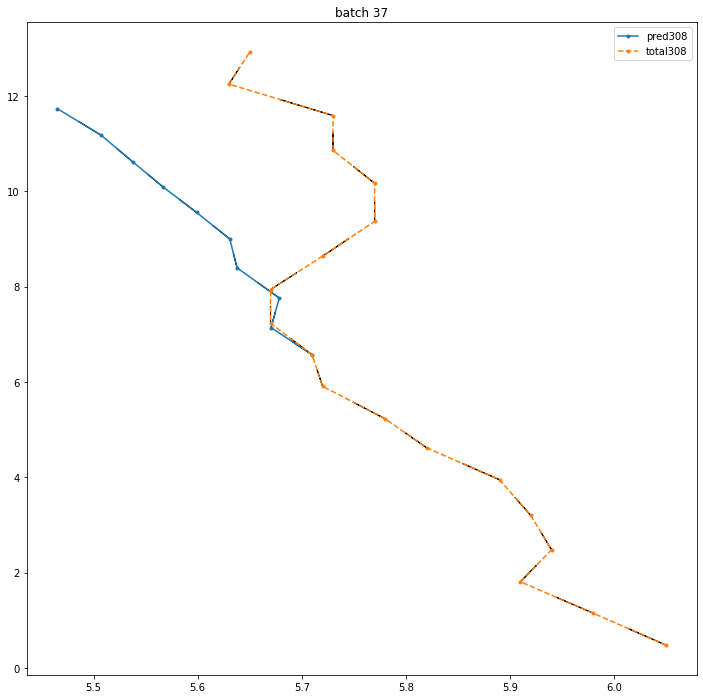

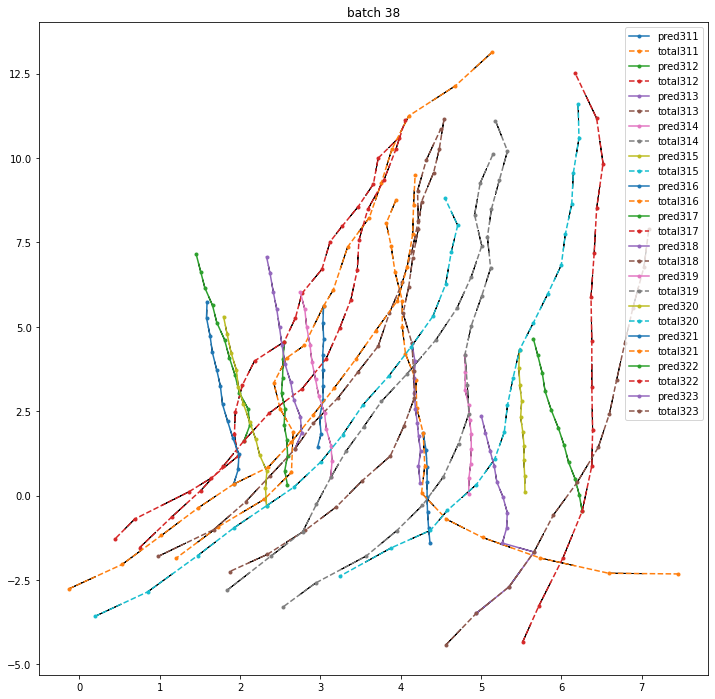

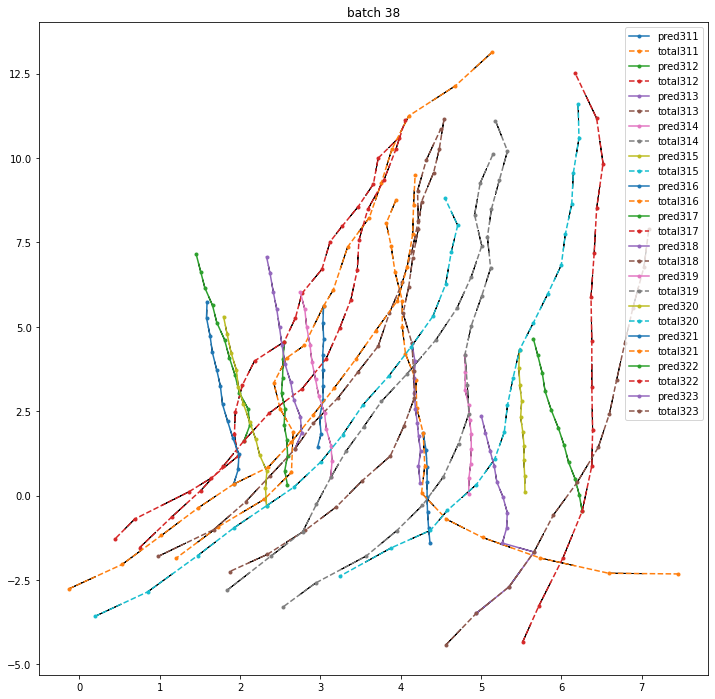

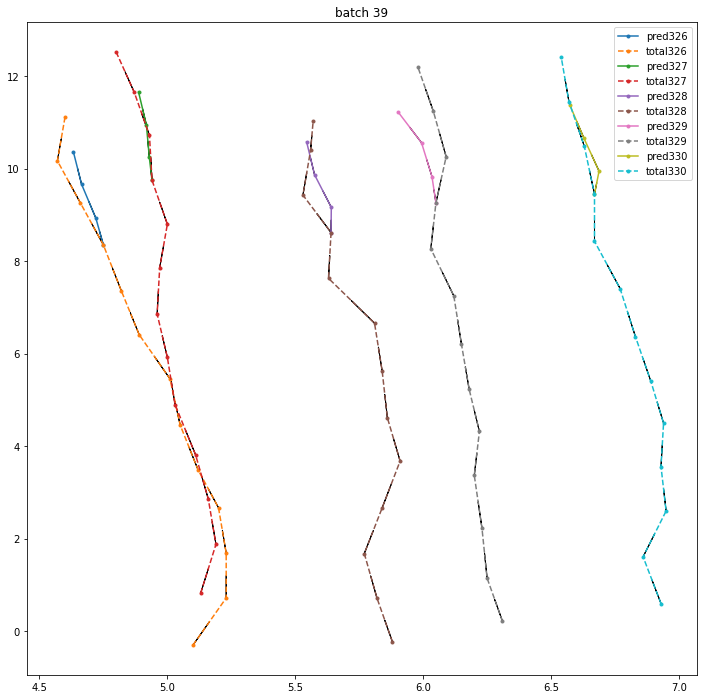

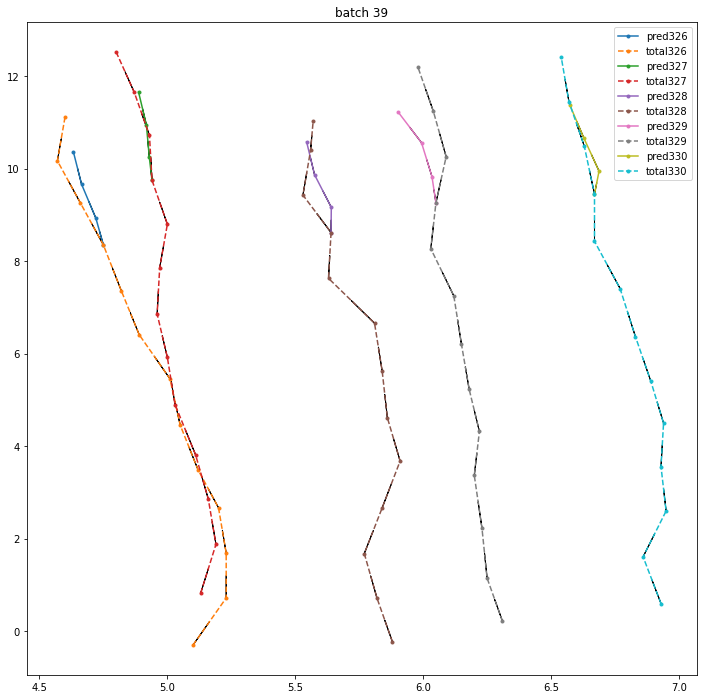

In [8]:
if __name__ == "__main__":
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"device {device}\n")

#     train_datasets = ["datasets/eth/train",
#                       "datasets/hotel/train",               
#                       "datasets/univ/train",
#                       "datasets/zara1/train",
#                       "datasets/zara2/train"
#                      ]
#     val_datasets = ["datasets/eth/test",
#                     "datasets/hotel/test",               
#                     "datasets/univ/test",
#                     "datasets/zara1/test",
#                     "datasets/zara2/test"
#                     ]
#     names = ["eth_sl.pt",
#              "hotel_sl.pt",
#              "univ_sl.pt",
#              "zara1_sl.pt",
#              "zara2_sl.pt"
#             ]
    
#     for train_dataset, val_dataset, name in zip(train_datasets, val_datasets, names):
#         #preparing training set
#         files_dir = train_dataset
#         print(f"pulling from dir {files_dir}")
#         files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
#         sl = None
#         #training
#         for file in files:
#             sl = train(8, 20, file, model=sl, name=name)

#         sl1 = torch.load(name)
#         print(f"loading from {name}")
#     #     validate(vl1, 8, 20, "try_dataset.txt")       
#         #preparing validating set
#         files_dir = val_dataset
#         print(f"pulling from dir {files_dir}")        
#         files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
#         #validating
#         for file in files:
#             validate(sl1, 8, 20, file)   
            
#         print("====================================")

#     temp = train(8, 20, "try_dataset1.txt")
#     validate(temp, 8, 20, "try_dataset1.txt")


    #preparing training set
    files_dir = "datasets/eth/train"
    name = "eth_slnew.pt"
    print(f"pulling from dir {files_dir}")
    files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
    sl = None
    #training
    for file in files:
        sl = train(8, 20, file, model=sl, name=name)

    sl1 = torch.load("eth_slnew.pt")
    print(f"loading from eth_slnew.pt")
#     validate(vl1, 8, 20, "try_dataset.txt")       
    #preparing validating set
    files_dir = "datasets/eth/test"
    print(f"pulling from dir {files_dir}")        
    files = [join(files_dir, f) for f in listdir(files_dir) if isfile(join(files_dir, f))]
    #validating
    for file in files:
        validate(sl1, 8, 20, file)       

In [9]:
def Gaussian2D(params, y):
    (mu_x,mu_y), (sig_x,sig_y), rho_xy = (params[0],params[1]), (params[2],params[3]), params[4]
    covariance = rho_xy*sig_x*sig_y
    rv = MultivariateNormal(torch.Tensor([mu_x, mu_y]), torch.Tensor([[sig_x, covariance], [covariance, sig_y]]))
    logP = rv.log_prob(y)
    print("(mu_x,mu_y)", (mu_x,mu_y))
    print("(sig_x,sig_y", (sig_x,sig_y))
    print("rho_xy", rho_xy)
    print("y",y)
    print("logP", logP)
    if logP > 1500:
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
    logP.requires_grad = True
    return logP


def Gaussian2DNll(all_params, targets):
    print("\n==================================================================================\n")

    traj_num = targets.shape[1]
    T = targets.shape[0]

    L = torch.zeros(traj_num)
    for traj in range(traj_num):
        for t in range(T):
            print('--------------------------------------')
            print("L", traj, L[traj],'\n')
            L[traj] += Gaussian2D(all_params[t][traj], targets[t][traj])
    L *= -1

    cost = torch.sum(L)

    return cost